### 📚 __Introduction__

The online store __Ice__ sells video games worldwide. It features a dataset containing user and expert reviews, genres, platforms (e.g., Xbox or PlayStation), and the rating that stores the __ESRB__ rating for each game. The _Entertainment Software Rating Board_ evaluates a game's content and assigns an age rating of either Teen or Mature, along with historical data on game sales.

#### 🧾 __Data Dictionary__

- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in millions of US dollars)
- EU_sales (European sales in millions of US dollars)
- JP_sales (Japanese sales in millions of US dollars)
- Other_sales (Other sales in other countries in millions of US dollars)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)

### 🎯 Objective

Identify patterns that determine whether a game is successful or not. This will allow you to identify promising projects and plan advertising campaigns.

### ✅ __Actions to be performed__

1. Data Preparation

- Replace column names (snake_case or lower case).
- Convert data to the necessary dtypes.
- Description of the columns where the data types have been changed and the reason.
- Processing of missing values.
- Feature engineering.

2. Data Analysis

- Game releases in different years.
- Sales variation from one platform to another.
- Selection of periods for data sample construction.
- Leading platforms, growth, profitability.
- Global sales, average sales.
- Correlation between user and professional reviews and sales of a platform.
- Comparison of sales of the same games on other platforms.
- General distribution of games by genre.

3. Creating a User Profile for Each Region

For each region (NA, EU, JP, Other):

- The top five platforms.
- The top five genres.
- Influence of ratings on sales in individual regions.

4. Hypothesis Testing:

- The average user ratings for the Xbox One and PC platforms are the same.
- The average user ratings for the Action and Sports genres are different.

5. Overall Conclusion


### 💻 __1. Notebook Libraries and Customization__

In [ ]:
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy import stats as st
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm

pd.set_option('display.max_rows', 25)  # display max 25 rows
pd.set_option('display.max_columns', 25)  # display max 10 columns
# show max 15 characters in each column
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 150)  # Display max 150 characters in cell

### 💻 __2. Functions__

In [ ]:
# Function used to detect missing values ​​not treated as NAN due to the use of keep_defaukt_na=False
def missing_values_check(df):

    missing_values = ['', ' ', 'N/A', 'none', 'None',
                      'null', 'NULL', 'NaN', 'nan', 'NAN', 'nat', 'NaT']

    for column in df.columns:

        if df[column].isin(missing_values).any():

            display(HTML(
                f"> Null values ​​in column <i>'{column}'</i>: <b>{df[column].isin(missing_values).sum()}</b>"))

        else:

            display(
                HTML(f"> No null values ​​exist in column <i>'{column}'</i>"))

# Function used to assign pd.NA to missing values


def missing_values_replace(df):

    missing_values = ['', ' ', 'N/A', 'none', 'None',
                      'null', 'NULL', 'NaN', 'nan', 'NAN', 'nat', 'NaT']

    for column in df.columns:

        try:

            # (None, np.nan, pd.NA, pd.NaT)
            df[column] = df[column].apply(lambda x: pd.NA if pd.isna(x) else x)

            # (missing_values))
            df[column] = df[column].replace(missing_values, pd.NA)

        except Exception as e:

            display(
                HTML(f"> Column <i>'{column}'</i> could not be processed: {e}"))

    return df

# Function to normalize the format of the 'object' type (character strings)


def object_format_norm(df, include=None, exclude=None):

    if exclude is None:
        exclude = []

    if include is None:
        available_columns = [col for col in df.columns if col not in exclude]
    else:
        available_columns = [col for col in include if col not in exclude]

    for column in available_columns:

        if df[column].dtype == 'object':

            df[column] = df[column].str.replace(r'[^\w\s]', ' ', regex=True)
            df[column] = df[column].str.replace(r'\s+', '_', regex=True)
            df[column] = df[column].str.replace(r'__+', '_', regex=True)
            df[column] = df[column].str.lower()
            df[column] = df[column].str.strip()

        else:

            continue

    return df

# Function to normalize the format of the column titles


def title_format_norm(df):

    title_norm = {}

    for title in df.columns:

        nt = re.sub(r'[^\w\s]', ' ', title)
        nt = re.sub(r'\s+', '_', nt)
        nt = re.sub(r'__+', '_', nt)
        nt = nt.lower().strip()

        title_norm[title] = nt

    df = df.rename(columns=title_norm)

    return df

# Function to detect implicit duplicates


def detect_implicit_duplicates(df, include=None, exclude=None):

    def is_non_composite(value):
        return isinstance(value, str) and re.match(r'^[A-Za-z0-9]+$', value)

    display(HTML(f"> Detection of implicit <b>duplicated values:</b>\n"))

    # Column filtering
    if include:
        columns = [col for col in include if col in df.columns]
    elif exclude:
        columns = [col for col in df.columns if col not in exclude]
    else:
        columns = df.columns.tolist()

    for col in columns:
        display(HTML(f"\n> Processing column: <i>'{col}'</i>"))

    # Filtering of unique and non-composite values
    values = df[col].dropna().unique()
    values = [v for v in values if is_non_composite(v)]

    results = {}

    # tqdm used for progress bar
    for base in tqdm(values, desc=f"> Comparing column '{col}'", unit=" values"):
        matches = [other for other in values if base !=
                   other and base in other]
        if matches:
            results[base] = matches

    # Sorted results
    display(HTML(f"\n> Results for column <i>'{col}'</i>:"))
    if results:
        for base, matches in sorted(results.items()):
            print(f" '{base}' → {matches}")
    else:
        display(HTML("No implicit duplicates found."))

    # Display results
    if results:
        display(HTML("\n[> Only non-composite values]"))
        for col, base, found in results:
            print(f" [{col}] '{base}' → '{found}'")
    else:
        display(HTML("No implicit duplicates found."))

    return results


# Function to detect limit values ​​of outliers


def outlier_limit_bounds(df, column, bound='both'):

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    if bound == 'both':

        df_outliers_lb = df[(df[column] < lower_bound)]
        df_outliers_ub = df[(df[column] > upper_bound)]
        display(HTML(
            f"> Lower limit of outliers for column <i>'{column}'</i>: <b>{lower_bound}</b>"))
        display(HTML(
            f"> Upper limit of outliers for column <i>'{column}'</i>: <b>{upper_bound}</b>"))
        return df_outliers_lb, df_outliers_ub

    elif bound == 'upper':

        df_outliers_ub = df[(df[column] > upper_bound)]
        display(HTML(
            f"> Upper limit of outliers for column <i>'{column}'</i>: <b>{upper_bound}</b>"))
        return df_outliers_ub

    elif bound == 'lower':

        df_outliers_lb = df[(df[column] < lower_bound)]
        display(HTML(
            f"> Lower limit of outliers for column <i>'{column}'</i>: <b>{lower_bound}</b>"))
        return df_outliers_lb

    else:
        display(HTML(
            f"> Incorrect limit type, correct value avilable: <b>'both', 'upper', or 'lower'</b>"))

# Function to evaluate the central tendency of a sample


def evaluate_central_trend(df, column):

    cv = (df[column].std() / df[column].mean()) * 100
    display(HTML(
        f"> Coefficient of variation for column <i>'{column}'</i>: <b>{cv:.2f} %</b>"))

    if 0 <= cv <= 10:
        display(HTML(
            "> Very low variability: <i>very reliable mean</i>, it is suggested to use the <b>mean</b>."))
    elif 10 < cv <= 20:
        display(HTML(
            "> Moderate variability: <i>Reliable mean</i>, we suggest using the <b>mean</b>."))
    elif 20 < cv <= 30:
        display(HTML(
            "> Considerable variability: <i>Somewhat skewed mean</i>, we suggest using the <b>mean</b>."))
    else:
        display(HTML("> High variability: we suggest using the <b>median</b>."))

    print()

# Function to evaluate correlation values


def evaluate_correlation(df):

    for column_x in df.columns:

        if df[column_x].dtype != 'object':

            for column_y in df.columns:

                if df[column_y].dtype != 'object':

                    if column_x != column_y:

                        if 0.7 < df[column_x].corr(df[column_y]) <= 1.0:
                            display(HTML(
                                f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Strong correlation.<b/>"))

                        elif 0.3 < df[column_x].corr(df[column_y]) <= 0.7:
                            display(HTML(
                                f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Moderate correlation.<b/>"))
                        # elif 0 < df[column_x].corr(df[column_y]) <= 0.3:
                            # display(HTML(f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Weak correlation.<b/>"))
                        elif df[column_x].corr(df[column_y]) == 0:
                            display(HTML(
                                f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>There is no linear relationship between variables.<b/>"))
                        # elif -0.3 < df[column_x].corr(df[column_y]) < 0:
                            # display(HTML(f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Weak inverse correlation.<b/>"))
                        elif -0.7 < df[column_x].corr(df[column_y]) <= -0.3:
                            display(HTML(
                                f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Moderate inverse correlation.<b/>"))
                        elif -1.0 <= df[column_x].corr(df[column_y]) <= -0.7:
                            display(HTML(
                                f"> Correlation (<i>{column_x}</i>', <i>{column_y}</i>): {df[column_x].corr(df[column_y])} <br> <b>Strong inverse correlation .<b/>"))

### 🔁 __3. Data Loading__

In [6]:
df_games = pd.read_csv('../data/raw/games.csv',
                       header='infer', keep_default_na=False)
df_games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,,,
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,,,
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,,,
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,,,
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,,,
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,,,


### 🧹 __4. Data Cleanup__

##### **4.1** Standardization of column heading formats (Lower case)

In [7]:
# Standardize the format of the title values ​​of each column of the DataFrame in lowercase | snake_case
df_games = title_format_norm(df_games)
df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,,,
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,,,
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,,,
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,,,
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,,,
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,,,


In [8]:
# Confirmation of changing the format of column titles
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  object 
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  object 
 9   user_score       16715 non-null  object 
 10  rating           16715 non-null  object 
dtypes: float64(4), object(7)
memory usage: 1.4+ MB


##### **4.2** Standardization of string values ​​format

In [9]:
# Standardizes the format of the values ​​of the 'object' type columns of the DataFrame to lowercase | snake_case
df_games = object_format_norm(
    df_games, exclude=['year_of_release', 'critic_score', 'user_score', 'rating'])
df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super_mario_bros_,nes,1985.0,platform,29.08,3.58,6.81,0.77,,,
2,mario_kart_wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon_red_pokemon_blue,gb,1996.0,role_playing,11.27,8.89,10.22,1.00,,,
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,,,
16711,lma_manager_2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,,,
16712,haitaka_no_psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,,,
16713,spirits_spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,,,


##### **4.3** Explicit Duplicate Removal

In [ ]:
# Checking for explicit duplicate values ​​in a DataFrame
display(HTML(
    f">Number of rows with <i>explicit duplicates</i>: <b>{df_games.duplicated().sum()}</b>"))

##### **4.4** Implicit Duplicate Processing

In [11]:
# Analysis to identify implicit duplicate values ​​in a DataFrame
detect_implicit_duplicates(df_games, include=['name', 'platform', 'genre'])

> Comparing column 'genre': 100%|██████████| 11/11 [00:00<00:00, 34125.25 values/s]


{}

##### **4.5** Missing Value Analysis

In [12]:
# Detection of missing values ​​since the DataFrame was generated keeping the original missing values ​​(keep_default_na=False)
missing_values_check(df_games)

##### _4.5.1_ Asignacion de valores pd.NA a valores ausentes

In [13]:
# Replacing missing values ​​with pd.NA
df_games = missing_values_replace(df_games)
df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super_mario_bros_,nes,1985.0,platform,29.08,3.58,6.81,0.77,<NA>,<NA>,<NA>
2,mario_kart_wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon_red_pokemon_blue,gb,1996.0,role_playing,11.27,8.89,10.22,1.00,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,<NA>,<NA>,<NA>
16711,lma_manager_2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,<NA>,<NA>,<NA>
16712,haitaka_no_psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,<NA>,<NA>,<NA>
16713,spirits_spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,<NA>,<NA>,<NA>


##### `LSPL`

**_Note_:**

`"keep_default_na=False"` is used so that missing values ​​are later converted to "pd.NA". This is convenient because "pd.NA" provides:

- Consistency between data types
- Preservation of type integrity
- Cleaner logical operations
- Better control over missing data.

Since high performance and heavy computation are not required, it is appropriate to use "pd.NA".

In [ ]:
# Sample pd.NA values ​​in DataFrame
print(f"> Null values ​​pd.NA: \n\n{df_games.isna().sum()}")
print()

for columns in df_games.columns:

    display(HTML(
        f"pd.NA values in column <i>'{columns}'</i>: <br>{df_games.loc[df_games[columns].isna(), columns].value_counts(dropna=False)}<br>"))

> Null values ​​pd.NA: 

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64



##### _4.5.2_ Displaying Null Values

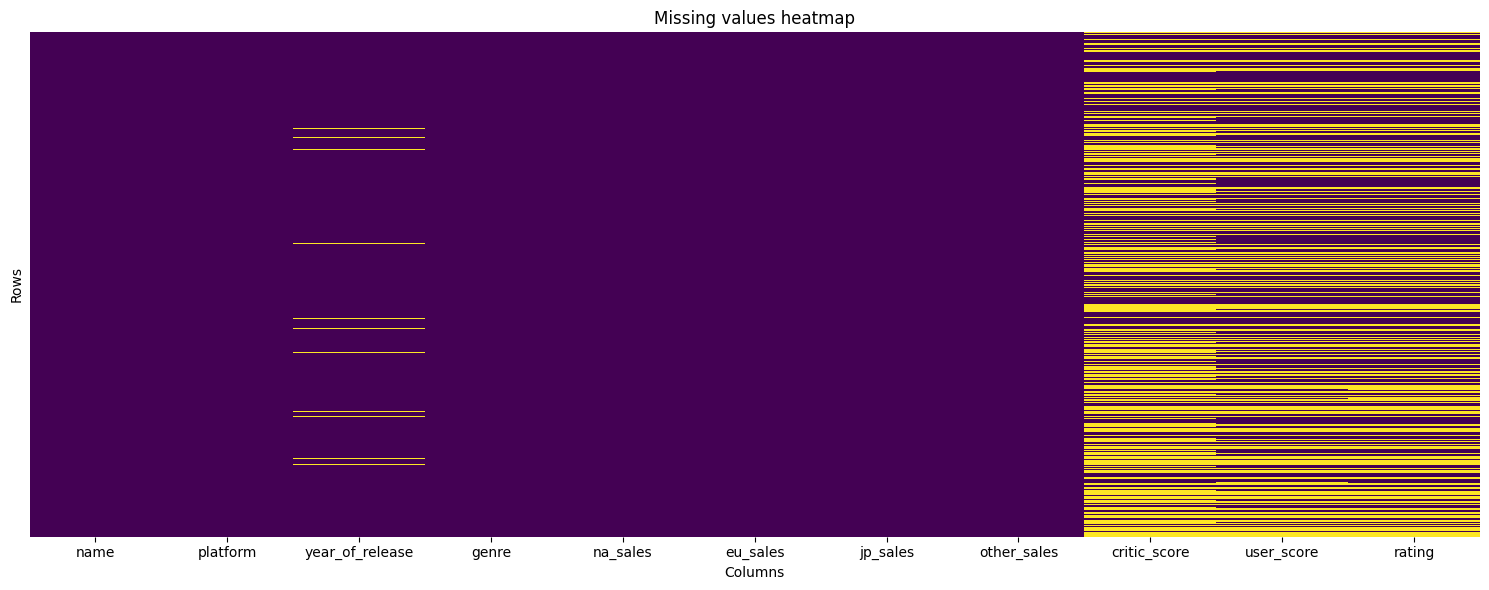

In [16]:
# Generation of heatmap of pd.NA values
plt.figure(figsize=(15, 6))
sns.heatmap(df_games.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing values heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

##### _4.5.3_ Missing values ​​in 'name' and 'genre' columns

In [17]:
# Checking for replacement of missing values ​​by pd.NA
print(df_games.loc[df_games['name'].isna(), :])

       name platform year_of_release genre  na_sales  eu_sales  jp_sales  other_sales critic_score user_score rating
659    <NA>      gen          1993.0  <NA>      1.78      0.53      0.00         0.08         <NA>       <NA>   <NA>
14244  <NA>      gen          1993.0  <NA>      0.00      0.00      0.03         0.00         <NA>       <NA>   <NA>


In [18]:
# Checking for replacement of missing values ​​by pd.NA
print(df_games.loc[df_games['genre'].isna(), :])

       name platform year_of_release genre  na_sales  eu_sales  jp_sales  other_sales critic_score user_score rating
659    <NA>      gen          1993.0  <NA>      1.78      0.53      0.00         0.08         <NA>       <NA>   <NA>
14244  <NA>      gen          1993.0  <NA>      0.00      0.00      0.03         0.00         <NA>       <NA>   <NA>


##### _4.5.4_ Missing values ​​in column 'year_of_release'

In [ ]:
# Percentage of null values ​​in column 'year_of_release'
display(HTML(
    f"> Percentage of null values ​​for column <i>'year_of_release'</i>: <b>{(df_games['year_of_release'].isna().sum() / len(df_games['year_of_release']) * 100):.2f}</b> %"))

In [20]:
# Confirmation of rows with pd.NA values ​​in the 'year_of_release' column that have significant sales values ​​to prevent their deletion from the dataset
mask = ((df_games['year_of_release'].isna()) & (df_games['na_sales'] == 0.00) & (
    df_games['eu_sales'] == 0.00) & (df_games['jp_sales'] == 0.00) & (df_games['other_sales'] == 0.00))
print(df_games.loc[mask, :])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


##### 4.5.5 Valores ausentes en columnas de scoring y rating

In [ ]:
# 4.5.5 Missing values ​​in scoring and rating columns
display(HTML(
    f"> Percentage of null values ​​for column <i>'critic_score'</i>: <b>{(df_games['critic_score'].isna().sum() / len(df_games['critic_score']) * 100):.2f}</b> %"))
display(HTML(
    f"> Percentage of null values ​​for column <i>'user_score'</i>: <b>{(df_games['user_score'].isna().sum() / len(df_games['user_score']) * 100):.2f}</b> %"))
display(HTML(
    f"> Percentage of null values ​​for column <i>'rating'</i>: <b>{(df_games['rating'].isna().sum() / len(df_games['rating']) * 100):.2f}</b> %"))

##### **4.6** Imputacion de valores ausentes

##### `LSPL`

**_Note_:**

For null values ​​in the 'name' and 'genre' columns, since they contain significant sales information, the missing values ​​in both columns also refer to the same records. Therefore, it was decided to keep the records, changing the null value to "unknown." Later, if this information is shown to be irrelevant, it could be isolated and not considered in the data processing.



##### _4.6.1_ Imputacion de valores faltandes para columna 'name' y 'genre'

In [ ]:
# Replacing pd.NA values ​​with 'unknown' in 'name' and 'genre' columns
df_games['name'] = df_games['name'].fillna("unknown")
df_games['genre'] = df_games['genre'].fillna("unknown")

In [23]:
# Confirmation of assignment of 'unknown' values ​​to columns 'name' and 'genre'
mask = (df_games['name'] == 'unknown') & (df_games['genre'] == 'unknown')
print(df_games.loc[mask, :])

          name platform year_of_release    genre  na_sales  eu_sales  jp_sales  other_sales critic_score user_score rating
659    unknown      gen          1993.0  unknown      1.78      0.53      0.00         0.08         <NA>       <NA>   <NA>
14244  unknown      gen          1993.0  unknown      0.00      0.00      0.03         0.00         <NA>       <NA>   <NA>


##### _4.6.2_ Imputation of missing values ​​for column 'year_of_release'

##### `LSPL`

**_Note_:**

For null values ​​in the "year_of_release" column, they contain significant sales information. Furthermore, the percentage of null values ​​is very low (1.61%), so it was decided to keep the records, changing the null value to "NA" after converting it to dtype (Int64). Later, if this information is shown to be irrelevant, it could be isolated and not considered in the data processing.


In [24]:
# Converting data type values ​​(object) in column 'year_of_release' to type (INT64)
df_games['year_of_release'] = pd.to_numeric(
    df_games['year_of_release'], errors='coerce').astype('Int64')

In [ ]:
# Sample data type (INT64) and existence of pd.NA values
print(
    f"> Unique values ​​for 'year_of_release' column: \n\n{df_games['year_of_release'].unique()}")

> Unique values ​​for 'year_of_release' column: 

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997,
 1993, 1994, 1982, 2016, 2003, 1986, 2000, <NA>, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 38, dtype: Int64


##### _4.6.3_ Missing value imputation analysis for scoring columns (user_score, critic_score)

##### `LSPL`

**_Note_:**

For the score values, the percentage does not significantly exceed 50%, so it is decided to impute in a segmented manner, taking the mean or median according to the bias of the groupings, to avoid a significant alteration in the data analysis. In the case of 'user_score', there are values ​​defined as (tbd - To Be Determined); these values ​​will also be imputed in a segmented manner, and then the mean or median will be applied according to the bias of the groupings.

In [26]:
print(df_games.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   object 
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(4), object(6)
memory usage: 1.4+ MB
None


In [27]:
# Analysis of values ​​from the 'user_score' column to determine how the imputation should be performed in a segmented manner
df_games[df_games.duplicated(subset=['name', 'genre'], keep=False)].sort_values(
    by=['name', 'genre'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1285,007_quantum_of_solace,x360,2008,action,0.82,0.51,0.01,0.14,65.0,7.1,T
1785,007_quantum_of_solace,ps3,2008,action,0.43,0.51,0.02,0.19,65.0,6.6,T
3120,007_quantum_of_solace,wii,2008,action,0.29,0.28,0.01,0.07,54.0,7.5,T
4475,007_quantum_of_solace,ps2,2008,action,0.17,0.00,0.00,0.26,<NA>,<NA>,<NA>
9507,007_quantum_of_solace,ds,2008,action,0.11,0.01,0.00,0.01,65.0,tbd,T
...,...,...,...,...,...,...,...,...,...,...,...
3516,zumba_fitness,ps3,2010,sports,0.28,0.21,0.00,0.08,<NA>,3.8,E
12439,zumba_fitness_core,wii,2012,misc,0.00,0.06,0.00,0.01,<NA>,tbd,E10+
13172,zumba_fitness_core,x360,2012,misc,0.00,0.05,0.00,0.00,77.0,6.7,E10+
6878,zumba_fitness_world_party,xone,2013,misc,0.17,0.05,0.00,0.02,73.0,6.2,E


##### _4.6.4_ Imputation of missing values ​​for 'user_score' columns

##### `LSPL`

**_Note_:**

Analyze the values ​​in the 'user_score' column to determine how to segment the column to obtain the mean or median. You can see that it's best to obtain the mean or median of the 'user_score' column by grouping the columns 'name' (for the mean or median) and 'genre' (in cases where the game name doesn't have any significant value for obtaining the mean or median).
Assign this value to null or NA values.

##### 'user_score'

In [28]:
# Unique values ​​are printed to show that <NA> and 'tbd' values ​​exist
print(df_games['user_score'].unique())

['8' <NA> '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [29]:
# Replacing 'tbd' values ​​with pd.NA
df_games['user_score'] = df_games['user_score'].replace('tbd', pd.NA)

In [30]:
# Confirmation of existence of pd.NA values ​​and cleaning of 'tbd' values
print(df_games['user_score'].unique())

['8' <NA> '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' '8.8' '6.9' '9.4'
 '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7' '4.1'
 '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3' '4.7'
 '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8' '1.8'
 '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2' '2.3'
 '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [31]:
# Converting values ​​in 'user_score' column from type (object) to (Float64)
df_games['user_score'] = pd.to_numeric(
    df_games['user_score'], errors='coerce').astype('Float64')

In [32]:
# Confirmation of conversion to data type (Float64)
print(df_games['user_score'].unique())

<FloatingArray>
[ 8.0, <NA>,  8.3,  8.5,  6.6,  8.4,  8.6,  7.7,  6.3,  7.4,  8.2,  9.0,  7.9,  8.1,  8.7,  7.1,  3.4,  5.3,  4.8,  3.2,  8.9,  6.4,  7.8,  7.5,
  2.6,  7.2,  9.2,  7.0,  7.3,  4.3,  7.6,  5.7,  5.0,  9.1,  6.5,  8.8,  6.9,  9.4,  6.8,  6.1,  6.7,  5.4,  4.0,  4.9,  4.5,  9.3,  6.2,  4.2,
  6.0,  3.7,  4.1,  5.8,  5.6,  5.5,  4.4,  4.6,  5.9,  3.9,  3.1,  2.9,  5.2,  3.3,  4.7,  5.1,  3.5,  2.5,  1.9,  3.0,  2.7,  2.2,  2.0,  9.5,
  2.1,  3.6,  2.8,  1.8,  3.8,  0.0,  1.6,  9.6,  2.4,  1.7,  1.1,  0.3,  1.5,  0.7,  1.2,  2.3,  0.5,  1.3,  0.2,  0.6,  1.4,  0.9,  1.0,  9.7]
Length: 96, dtype: Float64


In [33]:
# Average value for column 'user_score'
print(df_games[['user_score']].describe())

       user_score
count      7590.0
mean     7.125046
std      1.500006
min           0.0
25%           6.4
50%           7.5
75%           8.2
max           9.7


In [34]:
# Confidence decision using the mean based on the coefficient of variability
evaluate_central_trend(df_games, 'user_score')

<table>
  <thead>
    <tr>
      <th>CV (%)</th>
      <th>Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><small><strong>0–10%</strong></small></td>
      <td><strong>very low</strong><small> Variability  → <strong>very reliable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>10–20%</strong></small></td>
      <td><strong>moderate</strong><small> Variability  → <strong>trustable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>20–30%</strong></small></td>
      <td><strong>substantial</strong><small> Variability  → <strong>somewhat skewed mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>>30%</strong></small></td>
      <td><strong>high</strong><small> Variability  → <strong>prefer median</strong></small></td>
    </tr>
  </tbody>
</table>


In [35]:
# The mean is defined to replace the pd.NA values ​​for the case where the game contains significant values ​​to obtain the mean
ds_mean_name_user_score = df_games.groupby(
    'name')['user_score'].mean().round(3)
ds_mean_name_user_score

name
007_quantum_of_solace                          6.875
007_racing                                       4.6
007_the_world_is_not_enough                      6.7
007_tomorrow_never_dies                         <NA>
1000_cooking_recipes_from_elle_à_table          <NA>
                                               ...  
zumba_fitness_core                               6.7
zumba_fitness_rush                               6.2
zumba_fitness_world_party                        6.2
zwei_                                           <NA>
zyuden_sentai_kyoryuger_game_de_gaburincho_     <NA>
Name: user_score, Length: 11533, dtype: Float64

In [36]:
# Replacing pd.NA values ​​in 'user_score' with the average of the records with significant values
mapped_means_name = df_games['name'].map(ds_mean_name_user_score)
mask_name = df_games['user_score'].isna() & mapped_means_name.notna()
df_games.loc[mask_name, 'user_score'] = mapped_means_name[mask_name]

df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,<NA>,<NA>,<NA>
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,<NA>,<NA>,<NA>
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,<NA>,<NA>,<NA>
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,<NA>,<NA>,<NA>
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,<NA>,<NA>,<NA>


In [37]:
# The mean is defined to replace the pd.NA values ​​for the case in which the game does not contain significant values ​​to obtain the mean
ds_mean_genre_user_score = df_games.groupby(
    'genre')['user_score'].mean().round(3)
ds_mean_genre_user_score

genre
action          7.022
adventure       7.008
fighting         7.29
misc            6.778
platform        7.231
puzzle          7.088
racing          6.998
role_playing    7.632
shooter         7.023
simulation      7.119
sports           6.93
strategy        7.309
unknown          <NA>
Name: user_score, dtype: Float64

In [ ]:
# Replacing pd.NA values ​​in 'user_score' with the average of the records with significant values
mapped_means_genre = df_games['genre'].map(ds_mean_genre_user_score)
mask_genre = df_games['user_score'].isna(
) & mapped_means_name.isna() & mapped_means_genre.notna()
df_games.loc[mask_genre, 'user_score'] = mapped_means_genre[mask_genre]

df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,<NA>,7.231,<NA>
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,<NA>,7.632,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,<NA>,7.022,<NA>
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,<NA>,6.93,<NA>
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,<NA>,7.008,<NA>
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,<NA>,7.231,<NA>


In [39]:
df_games['user_score'].isna().sum()

np.int64(2)

In [40]:
df_games.loc[df_games['user_score'].isna(), :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,gen,1993,unknown,1.78,0.53,0.00,0.08,<NA>,<NA>,<NA>
14244,unknown,gen,1993,unknown,0.00,0.00,0.03,0.00,<NA>,<NA>,<NA>


In [41]:
df_games.loc[df_games['platform'] == 'gen', :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
145,sonic_the_hedgehog_2,gen,1992,platform,4.47,1.20,0.16,0.19,<NA>,7.231,<NA>
257,sonic_the_hedgehog,gen,1991,platform,3.03,0.91,0.26,0.13,<NA>,4.2,<NA>
564,mortal_kombat,gen,1992,fighting,1.95,0.63,0.00,0.09,<NA>,8.167,<NA>
588,streets_of_rage,gen,1990,action,1.86,0.55,0.11,0.08,<NA>,7.022,<NA>
659,unknown,gen,1993,unknown,1.78,0.53,0.00,0.08,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
13343,beyond_oasis,gen,1993,role_playing,0.00,0.00,0.05,0.00,<NA>,7.632,<NA>
14085,j_league_pro_striker_2,gen,1994,sports,0.00,0.00,0.04,0.00,<NA>,6.93,<NA>
14132,castlevania_bloodlines,gen,1994,platform,0.00,0.00,0.04,0.00,<NA>,7.231,<NA>
14244,unknown,gen,1993,unknown,0.00,0.00,0.03,0.00,<NA>,<NA>,<NA>


In [42]:
# The mean is defined to replace the pd.NA values ​​for the case where the game contains significant values ​​to obtain the mean
mean_gen_1993_us = df_games.loc[(df_games['platform'] == 'gen') & (
    df_games['year_of_release'] == 1993), 'user_score'].mean().round(3)
df_games.loc[(df_games['name'] == 'unknown') & (
    df_games['platform'] == 'gen'), 'user_score'] = mean_gen_1993_us

In [43]:
# The mean is defined to replace the pd.NA values ​​for the case where the game contains significant values ​​to obtain the mean
mean_gen_1993_cs = df_games.loc[(df_games['platform'] == 'gen') & (
    df_games['year_of_release'] == 1993), 'critic_score'].mean()
df_games.loc[(df_games['name'] == 'unknown') & (
    df_games['platform'] == 'gen'), 'critic_score'] = mean_gen_1993_cs

In [44]:
df_games.loc[(df_games['name'] == 'unknown') &
             (df_games['platform'] == 'gen'), :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,gen,1993,unknown,1.78,0.53,0.00,0.08,NaN,7.216,<NA>
14244,unknown,gen,1993,unknown,0.00,0.00,0.03,0.00,NaN,7.216,<NA>


##### _4.6.5_ Imputation of missing values ​​for column 'critic_score'

##### 'critic_score'

In [45]:
df_games['critic_score'].unique()

array(['76.0', <NA>, '82.0', '80.0', '89.0', '58.0', '87.0', '91.0',
       '61.0', '97.0', '95.0', '77.0', '88.0', '83.0', '94.0', '93.0',
       '85.0', '86.0', '98.0', '96.0', '90.0', '84.0', '73.0', '74.0',
       '78.0', '92.0', '71.0', '72.0', '68.0', '62.0', '49.0', '67.0',
       '81.0', '66.0', '56.0', '79.0', '70.0', '59.0', '64.0', '75.0',
       '60.0', '63.0', '69.0', '50.0', '25.0', nan, '42.0', '44.0',
       '55.0', '48.0', '57.0', '29.0', '47.0', '65.0', '54.0', '20.0',
       '53.0', '37.0', '38.0', '33.0', '52.0', '30.0', '32.0', '43.0',
       '45.0', '51.0', '40.0', '46.0', '39.0', '34.0', '35.0', '41.0',
       '36.0', '28.0', '31.0', '27.0', '26.0', '19.0', '23.0', '24.0',
       '21.0', '17.0', '22.0', '13.0'], dtype=object)

In [46]:
# Conversion of values ​​in column 'critic_score' of type (object) to (Float64)
df_games['critic_score'] = pd.to_numeric(
    df_games['critic_score'], errors='coerce').astype('Float64')

In [47]:
# Confirmation of conversion to data type (Float64)
print(df_games['critic_score'].unique())

<FloatingArray>
[76.0, <NA>, 82.0, 80.0, 89.0, 58.0, 87.0, 91.0, 61.0, 97.0, 95.0, 77.0, 88.0, 83.0, 94.0, 93.0, 85.0, 86.0, 98.0, 96.0, 90.0, 84.0, 73.0, 74.0,
 78.0, 92.0, 71.0, 72.0, 68.0, 62.0, 49.0, 67.0, 81.0, 66.0, 56.0, 79.0, 70.0, 59.0, 64.0, 75.0, 60.0, 63.0, 69.0, 50.0, 25.0, 42.0, 44.0, 55.0,
 48.0, 57.0, 29.0, 47.0, 65.0, 54.0, 20.0, 53.0, 37.0, 38.0, 33.0, 52.0, 30.0, 32.0, 43.0, 45.0, 51.0, 40.0, 46.0, 39.0, 34.0, 35.0, 41.0, 36.0,
 28.0, 31.0, 27.0, 26.0, 19.0, 23.0, 24.0, 21.0, 17.0, 22.0, 13.0]
Length: 83, dtype: Float64


In [48]:
# Average value for column 'critic_score'
print(df_games[['critic_score']].describe())

       critic_score
count        8137.0
mean      68.967679
std       13.938165
min            13.0
25%            60.0
50%            71.0
75%            79.0
max            98.0


In [49]:
# Confidence decision of using the mean based on the coefficient of variability
evaluate_central_trend(df_games, 'critic_score')

<table>
  <thead>
    <tr>
      <th>CV (%)</th>
      <th>Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><small><strong>0–10%</strong></small></td>
      <td><strong>very low</strong><small> Variability  → <strong>very reliable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>10–20%</strong></small></td>
      <td><strong>moderate</strong><small> Variability  → <strong>trustable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>20–30%</strong></small></td>
      <td><strong>substantial</strong><small> Variability  → <strong>somewhat skewed mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>>30%</strong></small></td>
      <td><strong>high</strong><small> Variability  → <strong>prefer median</strong></small></td>
    </tr>
  </tbody>
</table>

In [50]:
# The mean is defined to replace the pd.NA values ​​for the case where the game contains significant values ​​to obtain the mean
ds_mean_name_critic_score = df_games.groupby(
    'name')['critic_score'].mean().round(3)
ds_mean_name_critic_score

name
007_quantum_of_solace                          63.8
007_racing                                     51.0
007_the_world_is_not_enough                    61.0
007_tomorrow_never_dies                        <NA>
1000_cooking_recipes_from_elle_à_table         <NA>
                                               ... 
zumba_fitness_core                             77.0
zumba_fitness_rush                             73.0
zumba_fitness_world_party                      73.0
zwei_                                          <NA>
zyuden_sentai_kyoryuger_game_de_gaburincho_    <NA>
Name: critic_score, Length: 11533, dtype: Float64

In [51]:
# Replace pd.NA values ​​in 'critic_score' with the average of the records with significant values
mapped_means_cs_name = df_games['name'].map(ds_mean_name_critic_score)
mask_cs_name = df_games['critic_score'].isna() & mapped_means_cs_name.notna()
df_games.loc[mask_cs_name, 'critic_score'] = mapped_means_cs_name[mask_cs_name]

df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,<NA>,7.231,<NA>
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,<NA>,7.632,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,<NA>,7.022,<NA>
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,<NA>,6.93,<NA>
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,<NA>,7.008,<NA>
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,<NA>,7.231,<NA>


In [52]:
# The mean is defined to replace the pd.NA values ​​for the case in which the game does not contain significant values ​​to obtain the mean
ds_mean_genre_critic_score = df_games.groupby(
    'genre')['critic_score'].mean().round(3)
ds_mean_genre_critic_score

genre
action          66.893
adventure       64.339
fighting        69.512
misc            66.335
platform        67.337
puzzle          67.293
racing          67.584
role_playing    73.024
shooter          69.98
simulation      68.211
sports          71.302
strategy        71.745
unknown           <NA>
Name: critic_score, dtype: Float64

In [53]:
# Replace pd.NA values ​​in 'critic_score' with the average of the records with significant values
mapped_means_cs_genre = df_games['genre'].map(ds_mean_genre_critic_score)
mask_cs_genre = df_games['critic_score'].isna(
) & mapped_means_cs_name.isna() & mapped_means_cs_genre.notna()
df_games.loc[mask_cs_genre, 'critic_score'] = mapped_means_cs_genre[mask_genre]

df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,<NA>
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,66.893,7.022,<NA>
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,71.302,6.93,<NA>
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,64.339,7.008,<NA>
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,67.337,7.231,<NA>


In [54]:
df_games['critic_score'].isna().sum()

np.int64(337)

In [55]:
df_games.loc[(df_games['critic_score'].isna()), :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
365,tomb_raider_iii_adventures_of_lara_croft,ps,1997,action,1.66,1.58,0.12,0.18,<NA>,8.2,<NA>
437,club_penguin_elite_penguin_force,ds,2008,adventure,1.87,0.97,0.00,0.30,<NA>,8.0,E
505,imagine_babyz,ds,2007,simulation,1.30,1.26,0.00,0.31,<NA>,7.7,E
524,imagine_fashion_designer,ds,2007,simulation,1.32,1.19,0.00,0.30,<NA>,7.6,E
572,hannah_montana,ds,2006,action,1.59,0.80,0.00,0.26,<NA>,6.7,E
...,...,...,...,...,...,...,...,...,...,...,...
16539,grand_prix_legends,pc,1997,racing,0.00,0.01,0.00,0.00,<NA>,7.5,E
16654,ben_10_omniverse_2,x360,2013,action,0.00,0.01,0.00,0.00,<NA>,5.1,E10+
16661,bookworm_deluxe,pc,2006,puzzle,0.01,0.00,0.00,0.00,<NA>,8.0,E
16672,metal_gear_solid_v_the_definitive_experience,xone,2016,action,0.01,0.00,0.00,0.00,<NA>,7.8,M


In [56]:
mapped_means_cs_genre = df_games['genre'].map(ds_mean_genre_critic_score)
mask_cs_genre = df_games['critic_score'].isna() & mapped_means_cs_genre.notna()
df_games.loc[mask_cs_genre, 'critic_score'] = mapped_means_cs_genre[mask_genre]

In [57]:
df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,<NA>
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,66.893,7.022,<NA>
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,71.302,6.93,<NA>
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,64.339,7.008,<NA>
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,67.337,7.231,<NA>


##### _4.6.6_ Imputation of missing values ​​for the 'rating' column

##### `LSPL`

**_Note_:**

For rating values, the percentage of null values ​​is low (40.48%), so it was decided to impute by assigning the value "unknown".

In [58]:
print(df_games['rating'].unique())

['E' <NA> 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


In [59]:
df_games['rating'] = df_games['rating'].astype(
    "string").fillna("unknown").astype(str)

In [60]:
print(df_games['rating'].unique())

['E' 'unknown' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


### 🔍 __5. Exploratory Analysis (EDA)__

In [ ]:
display(HTML(f"> Dataset: <i>df_games</i>"))
display(
    HTML(f"> Number of <i>rows</i> in the dataset: <b>{df_games.shape[0]}</b>"))
display(
    HTML(f"> Number of <i>columns</i> in the dataset: <b>{df_games.shape[1]}</b<"))

##### **5.1** Data dispersion analysis

In [62]:
print(df_games.describe())

       year_of_release      na_sales      eu_sales      jp_sales   other_sales  critic_score  user_score
count          16446.0  16715.000000  16715.000000  16715.000000  16715.000000       16378.0     16715.0
mean       2006.484616      0.263377      0.145060      0.077617      0.047342      68.54497    7.079149
std            5.87705      0.813604      0.503339      0.308853      0.186731     10.665262    1.095683
min             1980.0      0.000000      0.000000      0.000000      0.000000          13.0         0.0
25%             2003.0      0.000000      0.000000      0.000000      0.000000          65.0         6.8
50%             2007.0      0.080000      0.020000      0.000000      0.010000        68.211       7.022
75%             2010.0      0.240000      0.110000      0.040000      0.030000        73.024       7.632
max             2016.0     41.360000     28.960000     10.220000     10.570000          98.0         9.7


In [63]:
print(df_games.describe(include='object'))

                              name platform   genre   rating
count                        16715    16715   16715    16715
unique                       11533       31      13        9
top     need_for_speed_most_wanted      ps2  action  unknown
freq                            12     2161    3369     6766


##### _5.1.1_ Evaluation of the central tendency

In [ ]:

for columns in df_games.columns:

    if df_games[columns].dtype != 'object':
        display(
            HTML(f"> Evaluation of central tendency for column: <i>{columns}</i>"))
        evaluate_central_trend(df_games, columns)

<table>
  <thead>
    <tr>
      <th>CV (%)</th>
      <th>Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><small><strong>0–10%</strong></small></td>
      <td><strong>very low</strong><small> Variability  → <strong>very reliable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>10–20%</strong></small></td>
      <td><strong>moderate</strong><small> Variability  → <strong>trustable mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>20–30%</strong></small></td>
      <td><strong>substantial</strong><small> Variability  → <strong>somewhat skewed mean</strong></small></td>
    </tr>
    <tr>
      <td><small><strong>>30%</strong></small></td>
      <td><strong>high</strong><small> Variability  → <strong>prefer median</strong></small></td>
    </tr>
  </tbody>
</table>


##### `LSPL`

**_Note_:**

For the columns 'year_of_release', 'critic_score', and 'user_score', the MEAN will be used as the central tendency to assess the dispersion of the data in the dataset.

For the columns 'na_sales', 'eu_sales', 'jp_sales', and 'other_sales', the MEDIAN will be used as the central tendency to assess the dispersion of the data in the dataset.

##### _5.1.2_ Box plot for Median as central tendency

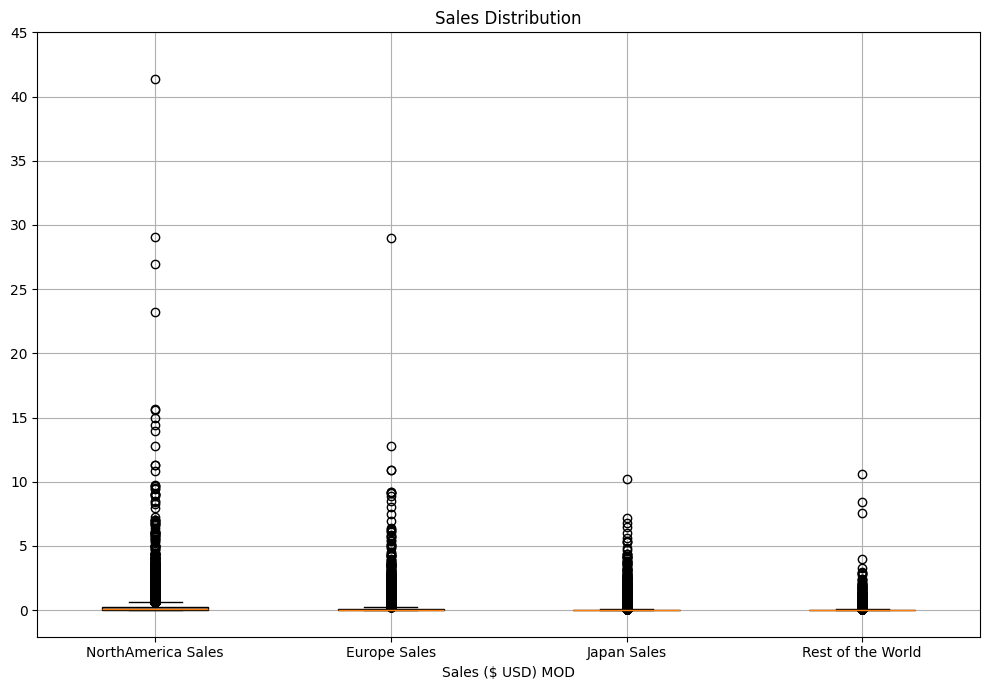

In [66]:
plt.figure(figsize=(10, 7))
plt.boxplot([df_games['na_sales'],
             df_games["eu_sales"],
             df_games["jp_sales"],
             df_games["other_sales"]],
            vert=True,
            patch_artist=True,
            boxprops=dict(facecolor='grey'))

plt.xlabel('Sales ($ USD) MOD')
plt.title('Sales Distribution')
plt.grid(True)
plt.xticks([1, 2, 3, 4], ['NorthAmerica Sales', 'Europe Sales',
           'Japan Sales', 'Rest of the World'])
plt.yticks(range(0, 50, 5), rotation=0)

plt.tight_layout()
plt.show()

In [67]:
na_ol = outlier_limit_bounds(df_games, 'na_sales', bound='upper')
display(HTML(f"> Sales identified as <b>outliers</b> for column <i>'na_sales'</i>:"))
na_ol

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,unknown
...,...,...,...,...,...,...,...,...,...,...,...
2972,nba_street_vol_2,xb,2003,sports,0.62,0.04,0.00,0.02,89.0,8.8,E
2976,ncaa_football_2005,xb,2004,sports,0.63,0.02,0.00,0.03,89.0,8.0,E
2992,cars_mater_national_championship,ds,2007,racing,0.63,0.00,0.00,0.05,69.0,6.8,E
3021,adventures_of_tron,2600,1981,action,0.63,0.03,0.00,0.01,66.893,7.022,unknown


In [68]:
eu_ol = outlier_limit_bounds(df_games, 'eu_sales', bound='upper')
display(HTML(f"> Sales identified as <b>outliers</b> for column <i>'eu_sales'</i>:"))
eu_ol

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,unknown
...,...,...,...,...,...,...,...,...,...,...,...
5508,we_sing_deutsche_hits,wii,2011,misc,0.00,0.29,0.00,0.04,66.335,6.778,unknown
5512,the_x_factor,wii,2010,misc,0.00,0.28,0.00,0.04,66.335,6.778,unknown
5594,batman_arkham_asylum,pc,2009,action,0.00,0.28,0.00,0.05,91.0,8.7,T
5757,gold_s_gym_cardio_workout_others_sales_,wii,2008,sports,0.00,0.29,0.00,0.02,71.302,6.93,unknown


In [69]:
jp_ol = outlier_limit_bounds(df_games, 'jp_sales', bound='upper')
display(HTML(f"> Sales identified as <b>outliers</b> for column <i>'jp_sales'</i>:"))
jp_ol

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,unknown
...,...,...,...,...,...,...,...,...,...,...,...
10398,mobile_suit_gundam_age_universe_accel_cosmic_d...,psp,2012,action,0.00,0.00,0.11,0.00,66.893,7.022,unknown
10401,dragon_ball_z_super_gokuden_kakusei_hen,snes,1995,role_playing,0.00,0.00,0.11,0.00,73.024,7.632,unknown
10402,busou_shinki_battle_masters_mk_2,psp,2011,action,0.00,0.00,0.11,0.00,66.893,7.022,unknown
10405,fate_extella_the_umbral_star,ps4,2016,action,0.00,0.00,0.11,0.00,66.893,7.022,T


In [70]:
other_ol = outlier_limit_bounds(df_games, 'other_sales', bound='upper')
display(HTML(f"> Sales identified as <b>outliers</b> for column <i>'other_sales'</i>:"))
other_ol

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,unknown
...,...,...,...,...,...,...,...,...,...,...,...
7515,buzz_the_schools_quiz,ps2,2008,misc,0.00,0.02,0.00,0.19,66.335,6.778,unknown
7893,monsters_vs_aliens,ps2,2009,action,0.11,0.00,0.00,0.08,64.0,5.767,E10+
8045,summer_athletics_the_ultimate_challenge,ps2,2008,sports,0.00,0.00,0.00,0.18,48.0,6.93,E
8784,the_secret_saturdays_beasts_of_the_5th_sun,ps2,2009,action,0.05,0.02,0.00,0.08,60.0,7.022,E10+


##### `LSPL`

**_Note_:**

Upper bounds for outliers are identified, and outliers are displayed for analysis.
Total records in the data frame: **16,715**
- Number of outliers for column *'na_sales'*: **1,687**
- Number of outliers for column *'eu_sales'*: **2,061**
- Number of outliers for column *'jp_sales'*: **2,434**
- Number of outliers for column *'other_sales'*: **2,243**

##### _5.1.3_ Histogram for 'year_of_release'

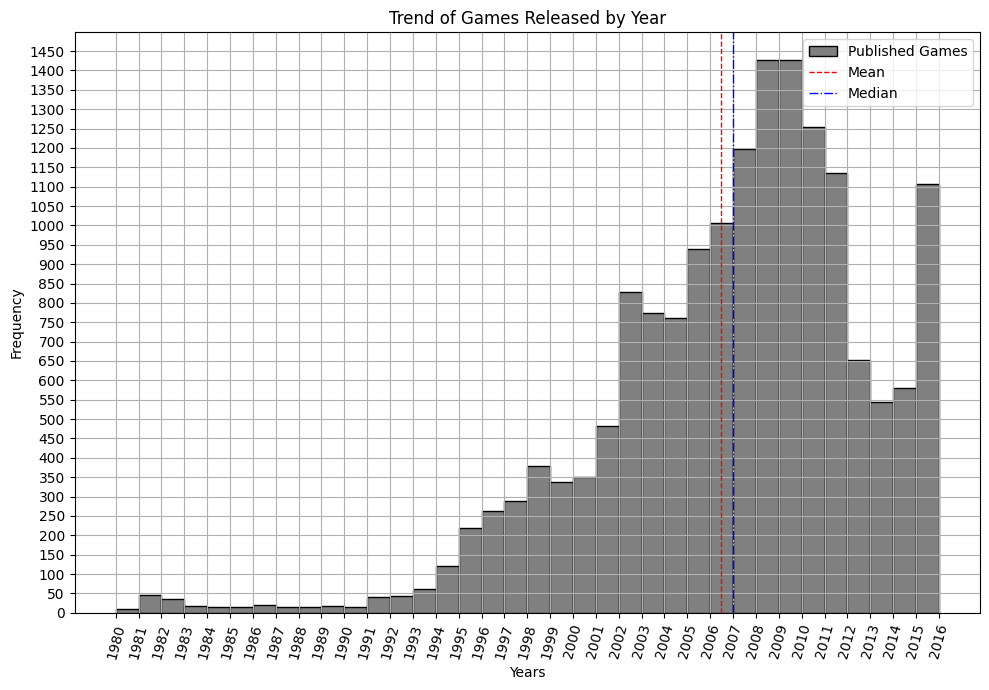

In [71]:
years_release = df_games['year_of_release']
mean = years_release.mean()
median = years_release.median()

bins = np.arange(1980, 2017, 1)

plt.figure(figsize=(10, 7))

plt.hist(df_games['year_of_release'], bins=bins,
         edgecolor='black', color='grey', label='Published Games')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='dashdot',
            linewidth=1, label='Median')
plt.title('Trend of Games Released by Year')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(1980, 2017, 1), rotation=75)
plt.yticks(range(0, 1500, 50), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.4_ Density Histogram 'na_sales'

In [72]:
games_na_sales = df_games['na_sales'] * 1000000
games_na_sales

0        41360000.0
1        29080000.0
2        15680000.0
3        15610000.0
4        11270000.0
            ...    
16710           0.0
16711           0.0
16712           0.0
16713       10000.0
16714           0.0
Name: na_sales, Length: 16715, dtype: float64

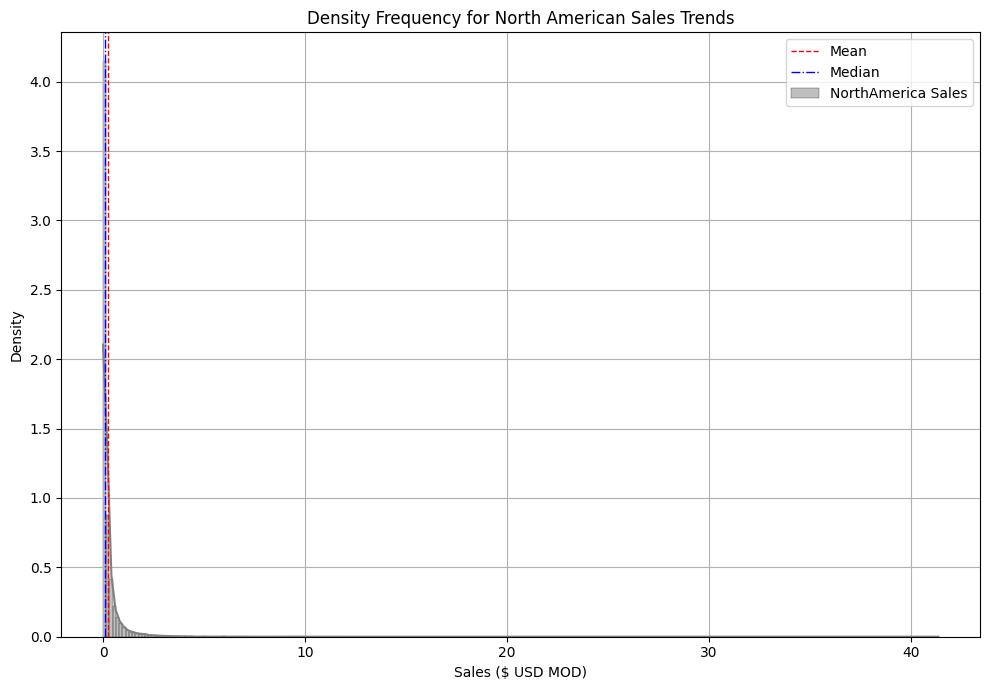

In [73]:
games_na_sales = df_games['na_sales']
mean = games_na_sales.mean()
median = games_na_sales.median()

plt.figure(figsize=(10, 7))

sns.histplot(games_na_sales, kde=True, stat="density",
             color='grey', label='NorthAmerica Sales')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Density Frequency for North American Sales Trends')
plt.xlabel('Sales ($ USD MOD)')
plt.ylabel('Density')
plt.grid(True)

plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.5_ Density histogram 'eu_sales'

In [74]:
games_eu_sales = df_games['eu_sales'] * 1000000
games_eu_sales

0        28960000.0
1         3580000.0
2        12760000.0
3        10930000.0
4         8890000.0
            ...    
16710           0.0
16711       10000.0
16712           0.0
16713           0.0
16714           0.0
Name: eu_sales, Length: 16715, dtype: float64

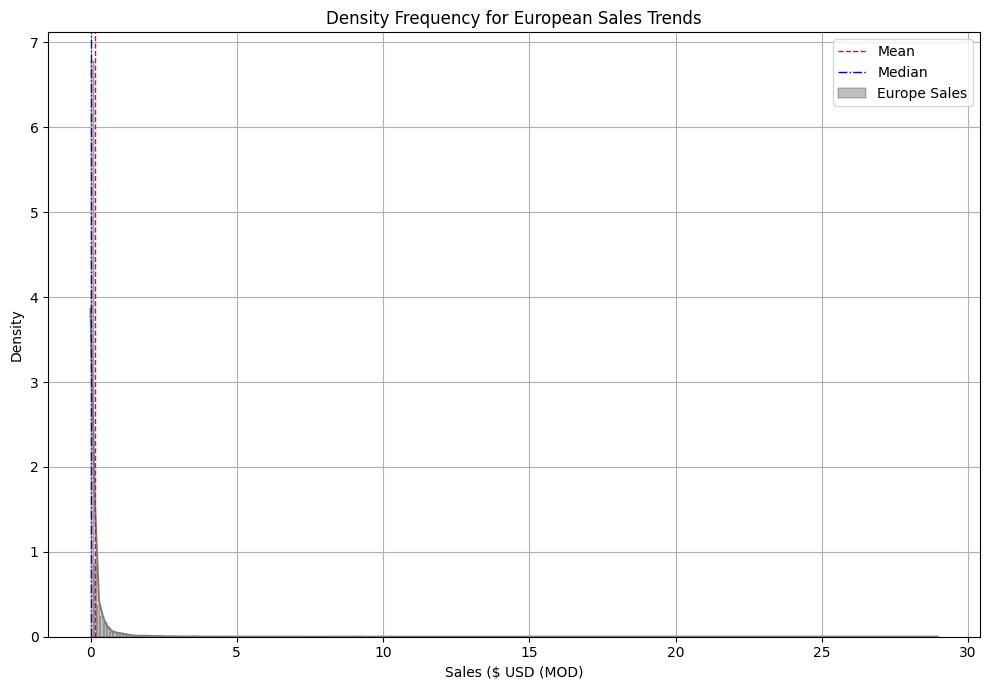

In [75]:
games_eu_sales = df_games['eu_sales']
mean = games_eu_sales.mean()
median = games_eu_sales.median()

plt.figure(figsize=(10, 7))

sns.histplot(games_eu_sales, kde=True, stat="density",
             color='grey', label='Europe Sales')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Density Frequency for European Sales Trends')
plt.xlabel('Sales ($ USD (MOD)')
plt.ylabel('Density')
plt.grid(True)

plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.6_ Density Histogram 'jp_sales'

In [76]:
games_jp_sales = df_games['jp_sales'] * 1000000
games_jp_sales

0         3770000.0
1         6810000.0
2         3790000.0
3         3280000.0
4        10220000.0
            ...    
16710       10000.0
16711           0.0
16712       10000.0
16713           0.0
16714       10000.0
Name: jp_sales, Length: 16715, dtype: float64

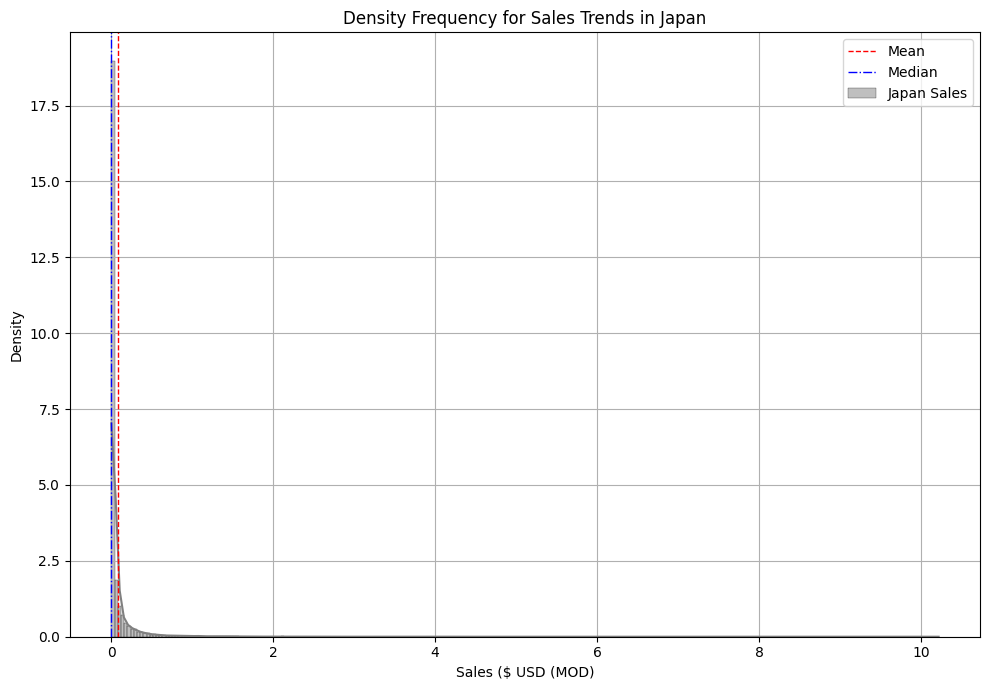

In [77]:
games_jp_sales = df_games['jp_sales']
mean = games_jp_sales.mean()
median = games_jp_sales.median()

plt.figure(figsize=(10, 7))

sns.histplot(games_jp_sales, kde=True, stat="density",
             color='grey', label='Japan Sales')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Density Frequency for Sales Trends in Japan')
plt.xlabel('Sales ($ USD (MOD)')
plt.ylabel('Density')
plt.grid(True)

plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.7_ Density Histogram 'other_sales'

In [78]:
games_oth_sales = df_games['other_sales'] * 1000000
games_oth_sales

0        8450000.0
1         770000.0
2        3290000.0
3        2950000.0
4        1000000.0
           ...    
16710          0.0
16711          0.0
16712          0.0
16713          0.0
16714          0.0
Name: other_sales, Length: 16715, dtype: float64

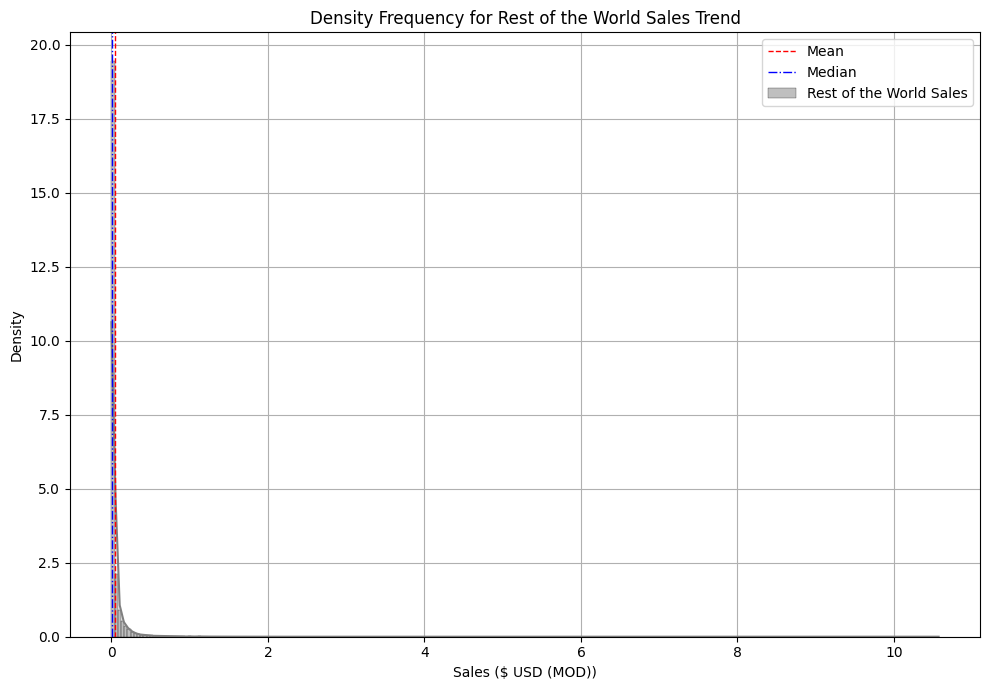

In [79]:
games_oth_sales = df_games['other_sales']
mean = games_oth_sales.mean()
median = games_oth_sales.median()

plt.figure(figsize=(10, 7))

sns.histplot(games_oth_sales, kde=True, stat="density",
             color='grey', label='Rest of the World Sales')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Density Frequency for Rest of the World Sales Trend')
plt.xlabel('Sales ($ USD (MOD))')
plt.ylabel('Density')
plt.grid(True)

plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.8_ Histogram 'user_score'

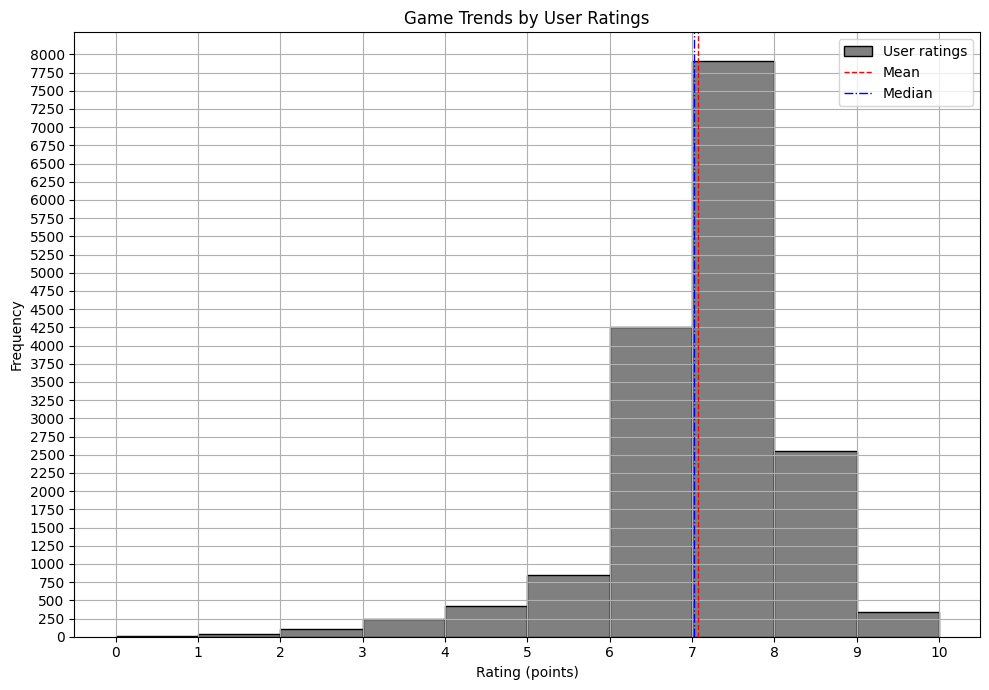

In [80]:
games_user_score = df_games['user_score']
mean = games_user_score.mean()
median = games_user_score.median()

bins = np.arange(0, 11, 1)

plt.figure(figsize=(10, 7))

plt.hist(df_games['user_score'], bins=bins, edgecolor='black',
         color='grey', label='User ratings')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='dashdot',
            linewidth=1, label='Median')
plt.title('Game Trends by User Ratings')
plt.xlabel('Rating (points)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 11, 1), rotation=0)
plt.yticks(range(0, 8250, 250), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

##### _5.1.9_ Histograma 'critic_score'

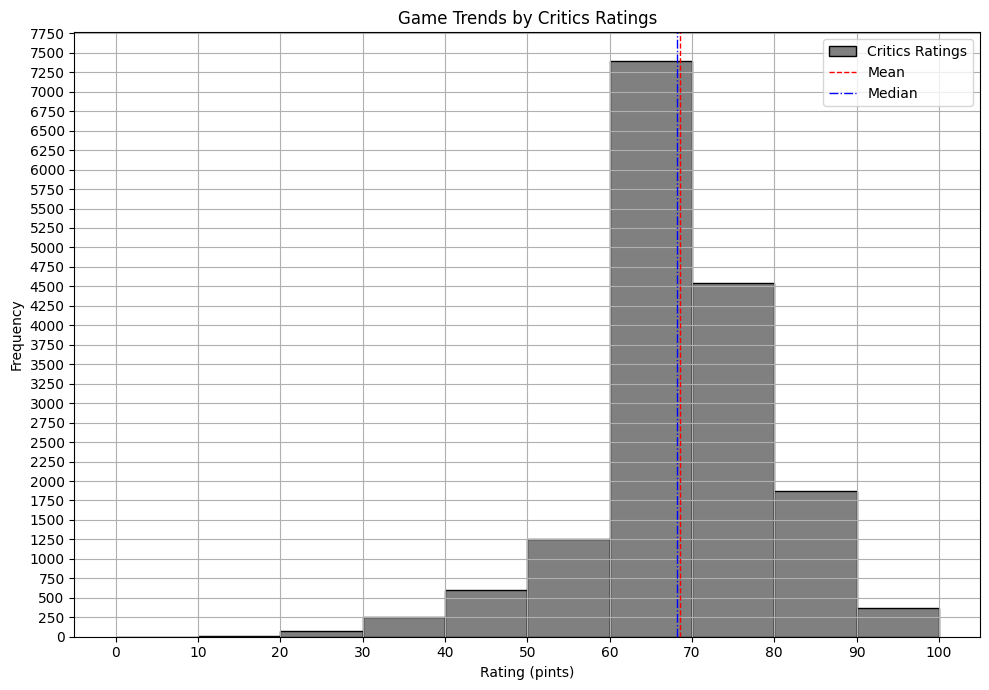

In [81]:
games_critic_score = df_games['critic_score']
mean = games_critic_score.mean()
median = games_critic_score.median()

bins = np.arange(0, 110, 10)

plt.figure(figsize=(10, 7))

plt.hist(df_games['critic_score'], bins=bins, edgecolor='black',
         color='grey', label='Critics Ratings')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='dashdot',
            linewidth=1, label='Median')
plt.title('Game Trends by Critics Ratings')
plt.xlabel('Rating (pints)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 110, 10), rotation=0)
plt.yticks(range(0, 8000, 250), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

##### **5.2** Relationship between variables

##### _5.2.1_ Covariance Matrix

In [82]:
df_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'], dtype='object')

In [83]:
df_games_cov = df_games.loc[:, ['year_of_release', 'na_sales',
                                'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']]
print(df_games_cov.cov())

                 year_of_release  na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score
year_of_release        34.539715 -0.444915  0.011845 -0.307815     0.041786     -0.458105   -0.903597
na_sales               -0.444915  0.661951  0.313418  0.112976     0.097027      1.592788    0.063814
eu_sales                0.011845  0.313418  0.253350  0.067634     0.067934      1.058330    0.030570
jp_sales               -0.307815  0.112976  0.067634  0.095390     0.016788      0.362612    0.033418
other_sales             0.041786  0.097027  0.067934  0.016788     0.034868      0.371857    0.011694
critic_score           -0.458105  1.592788  1.058330  0.362612     0.371857    113.747819    5.978936
user_score             -0.903597  0.063814  0.030570  0.033418     0.011694      5.978936    1.200520


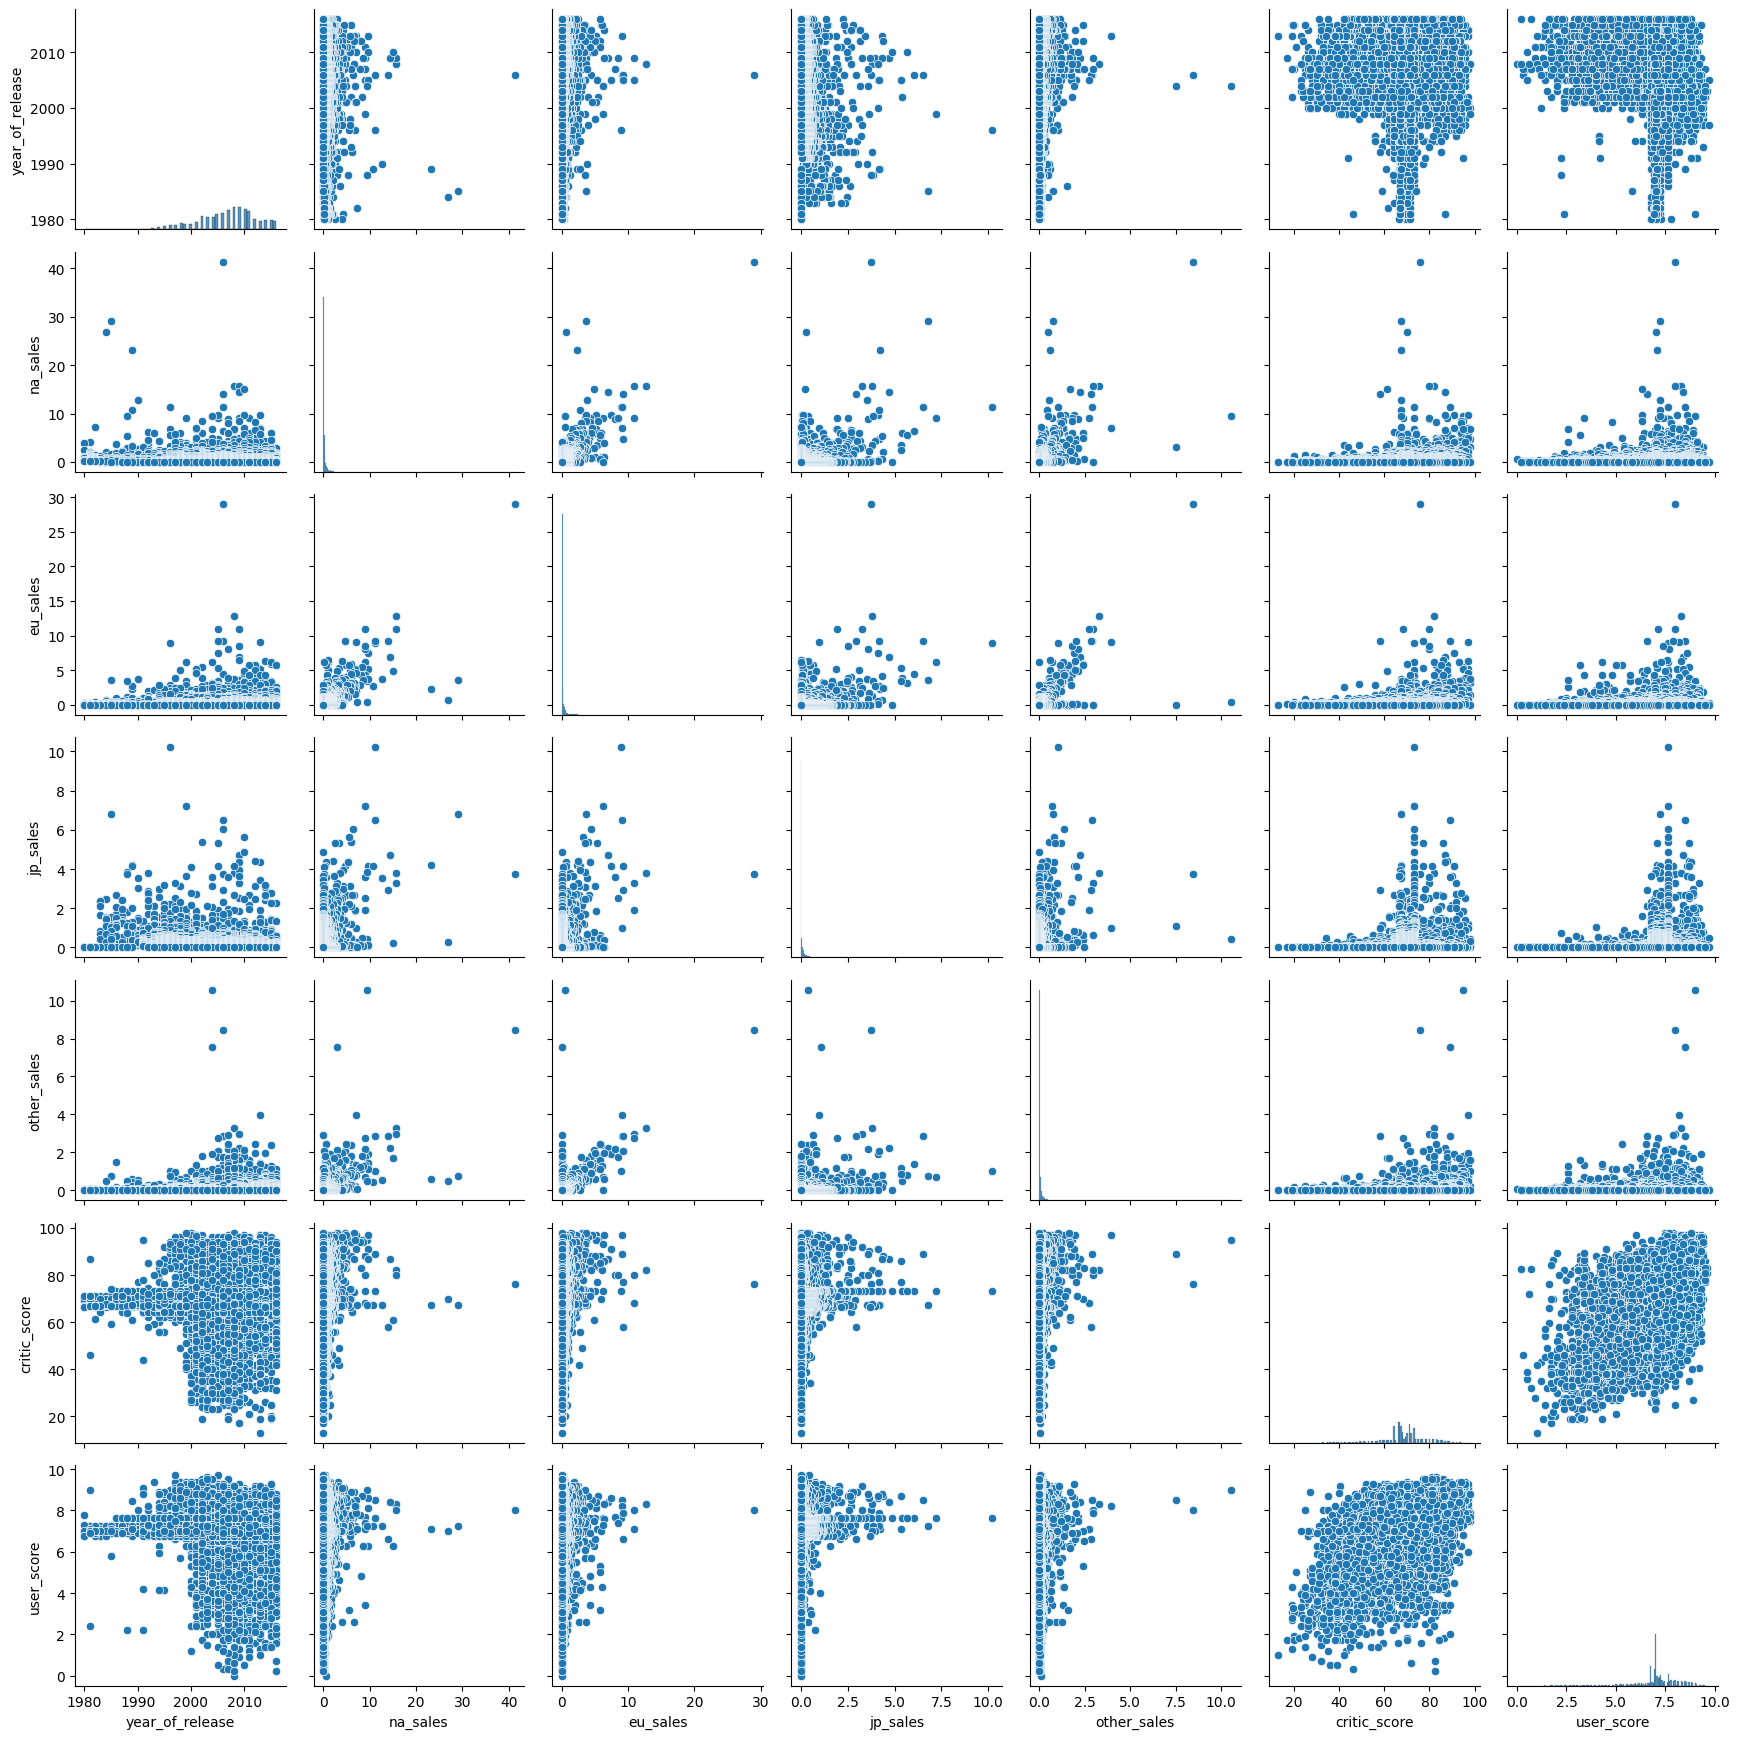

In [84]:
sns.pairplot(df_games_cov)
plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

- critic/user score, you can see dispersion, but there's a dense cloud indicating that when one goes up, the other does too. This confirms that the perception between critics and players isn't completely opposite, although there is noise.
- year_of_release and sales, High sales in NA, EU, JP, and global are concentrated between 1990 and 2015. After 2015, there's a clear decline in scores—perhaps due to a lack of data or a drop in new game releases in the dataset.
- Many games have very low sales, and a few games dominate.

##### _5.2.2_ Correlation Matrix

In [85]:
df_games_corr = df_games.loc[:, ['year_of_release', 'na_sales',
                                 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']]
print(df_games_corr.corr())

                 year_of_release  na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score
year_of_release         1.000000 -0.092500  0.003978 -0.168366     0.037820     -0.007297   -0.140388
na_sales               -0.092500  1.000000  0.765335  0.449594     0.638649      0.182008    0.071584
eu_sales                0.003978  0.765335  1.000000  0.435061     0.722792      0.195488    0.055431
jp_sales               -0.168366  0.449594  0.435061  1.000000     0.291089      0.109041    0.098750
other_sales             0.037820  0.638649  0.722792  0.291089     1.000000      0.184959    0.057156
critic_score           -0.007297  0.182008  0.195488  0.109041     0.184959      1.000000    0.527121
user_score             -0.140388  0.071584  0.055431  0.098750     0.057156      0.527121    1.000000


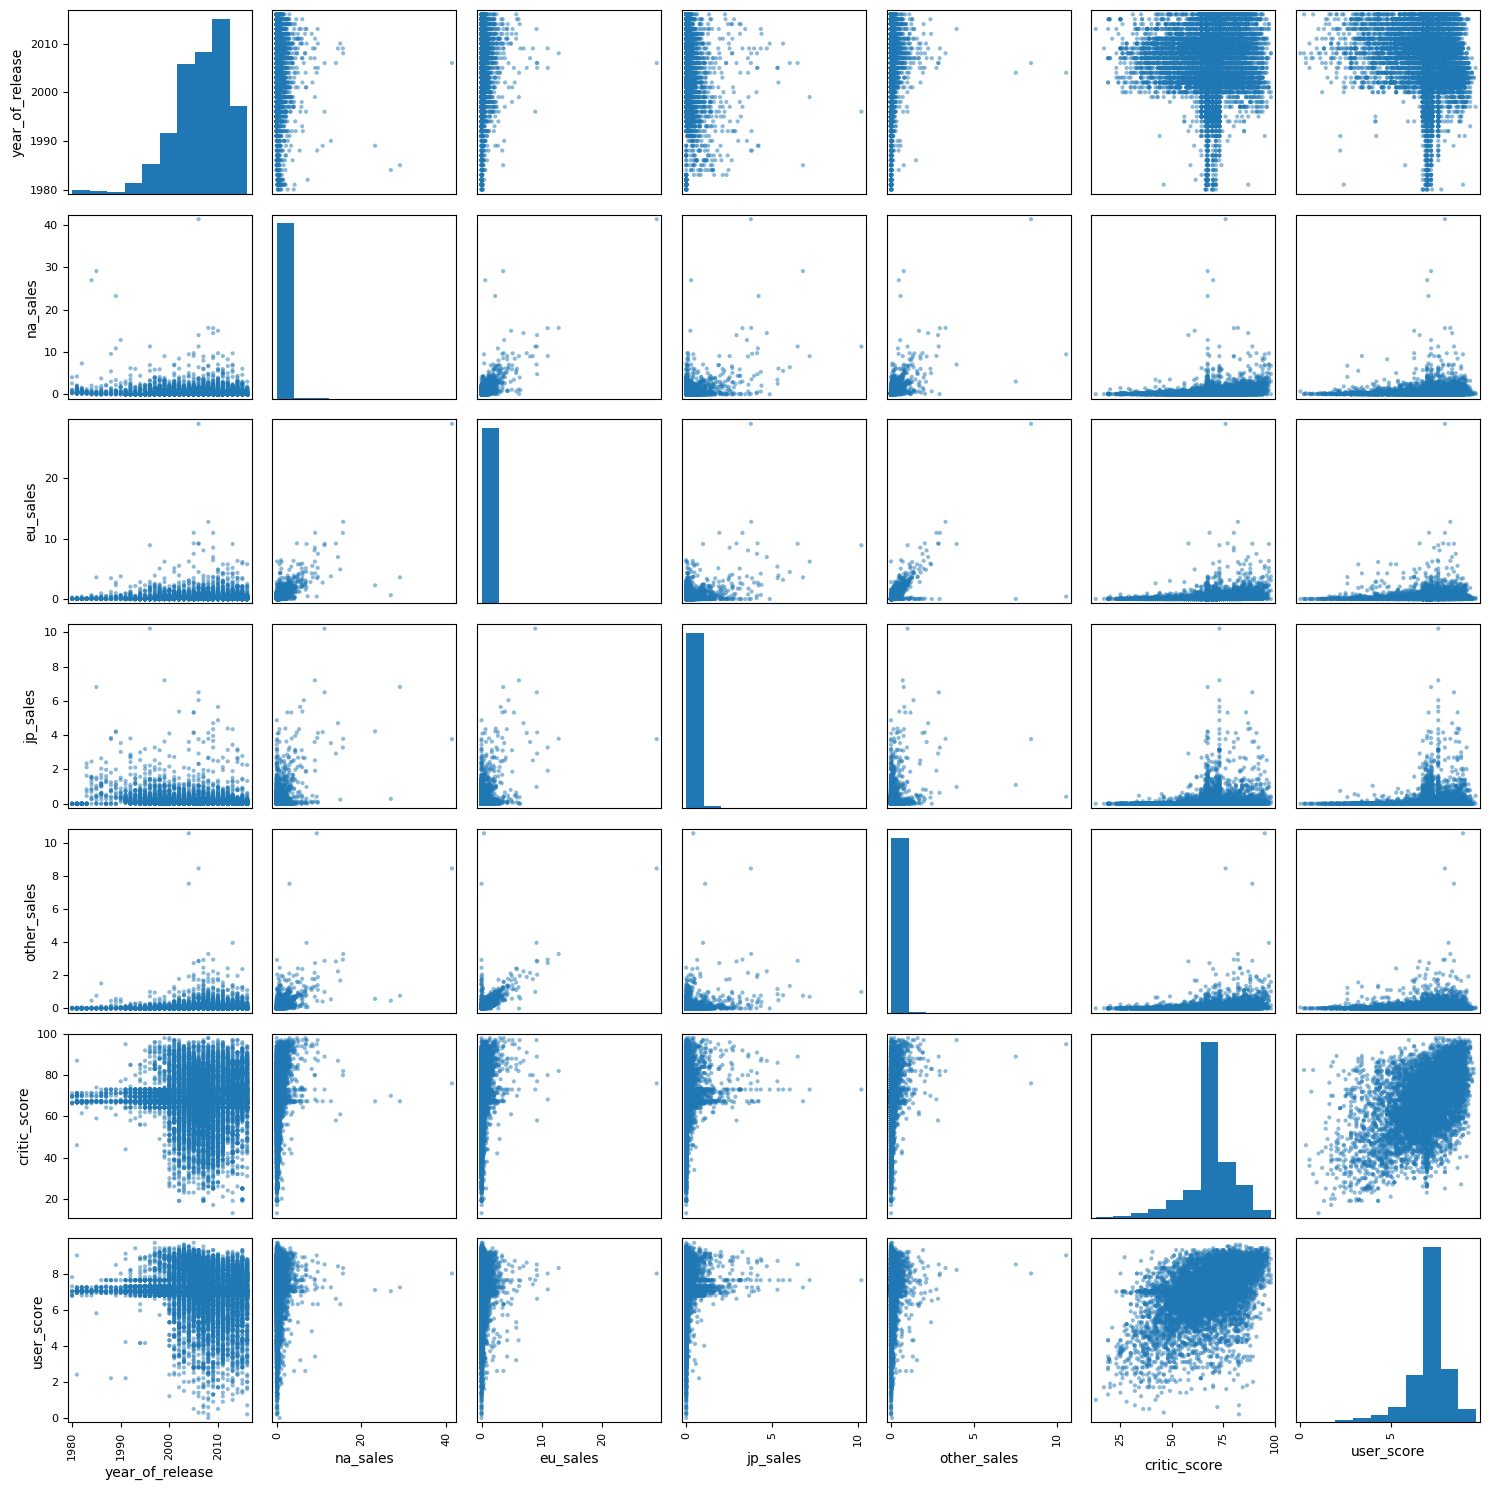

In [86]:
pd.plotting.scatter_matrix(df_games_corr, figsize=(15, 15))

plt.tight_layout()
plt.show()

In [ ]:
print(df_games_corr.corr())

| Correlation Value | Interpretation |
| -------------------- | ----------------------------- |
| `+0.7` to `+1.0` | Strong Positive Correlation |
| `+0.3` to `+0.7` | Moderate Correlation |
| `0.0` to `+0.3` | Weak Correlation |
| `0` | No Correlation |
| `-0.3` to `0` | Weak Negative Correlation |
| `-0.7` to `-0.3` | Moderate Negative Correlation |
| `-1.0` to `-0.7` | Strong Negative Correlation |


In [87]:
evaluate_correlation(df_games)

##### `LSPL`

**_Note_:**

- critic_score vs user_score: Clear and fairly linear positive relationship (the higher one, the higher the other)
- na_sales vs eu_sales: Slight relationship, but it exists. Games that sell well in NA also do well in EU.
- user_score and critic_score with sales: Not as strong visually, but there is a weak positive trend: higher-rated games sell slightly more.

##### **5.3** Exploratory Feature Engineering

In [88]:
print(df_games.describe())

       year_of_release      na_sales      eu_sales      jp_sales   other_sales  critic_score  user_score
count          16446.0  16715.000000  16715.000000  16715.000000  16715.000000       16378.0     16715.0
mean       2006.484616      0.263377      0.145060      0.077617      0.047342      68.54497    7.079149
std            5.87705      0.813604      0.503339      0.308853      0.186731     10.665262    1.095683
min             1980.0      0.000000      0.000000      0.000000      0.000000          13.0         0.0
25%             2003.0      0.000000      0.000000      0.000000      0.000000          65.0         6.8
50%             2007.0      0.080000      0.020000      0.000000      0.010000        68.211       7.022
75%             2010.0      0.240000      0.110000      0.040000      0.030000        73.024       7.632
max             2016.0     41.360000     28.960000     10.220000     10.570000          98.0         9.7


In [89]:
print(df_games.describe(include='object'))

                              name platform   genre   rating
count                        16715    16715   16715    16715
unique                       11533       31      13        9
top     need_for_speed_most_wanted      ps2  action  unknown
freq                            12     2161    3369     6766


##### _5.3.1_ Calculation of total sales

In [90]:
df_games['total_sales'] = df_games['na_sales'] + \
    df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']

##### _5.3.2_ Game Age

In [91]:
df_games['game_age'] = 2025 - df_games['year_of_release']

##### _5.3.3_ Average score (users and critics)

In [92]:
df_games['norm_critic_score'] = df_games['critic_score']/10
df_games['mean_score'] = df_games[[
    'norm_critic_score', 'user_score']].mean(axis=1)

##### _5.3.4_ Discrepancy between scores (users and critics)

In [93]:
df_games['score_gap'] = (
    df_games['norm_critic_score'] - df_games['user_score']).abs()

##### _5.3.5_ Number of platforms per game

In [94]:
platform_counts = df_games.groupby('name')['platform'].nunique()
df_games['platform_count'] = df_games['name'].map(platform_counts)
df_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,game_age,norm_critic_score,mean_score,score_gap,platform_count
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,19,7.6,7.8,0.4,1
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown,40.24,40,6.7337,6.98235,0.4973,2
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,17,8.2,8.25,0.1,1
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,16,8.0,8.0,0.0,1
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,73.024,7.632,unknown,31.38,29,7.3024,7.4672,0.3296,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,66.893,7.022,unknown,0.01,9,6.6893,6.85565,0.3327,3
16711,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,71.302,6.93,unknown,0.01,19,7.1302,7.0301,0.2002,1
16712,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,64.339,7.008,unknown,0.01,9,6.4339,6.72095,0.5741,1
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,67.337,7.231,unknown,0.01,22,6.7337,6.98235,0.4973,2


### 📈 __6. Data Visualization__

##### **6.1** Tendencia de publicacion de juegos por año

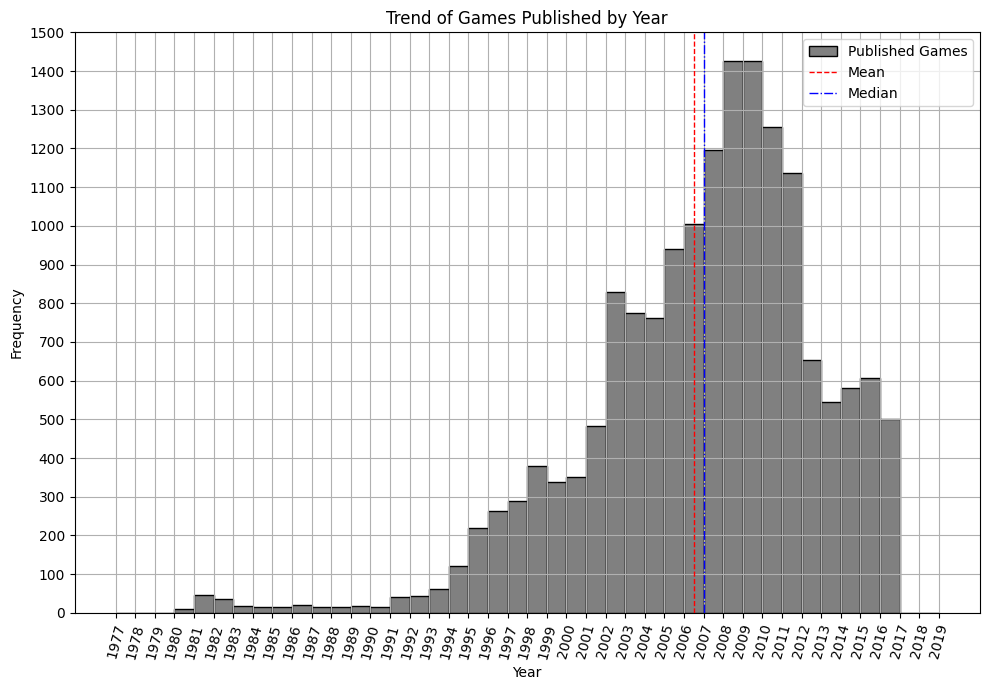

In [98]:
mean = df_games['year_of_release'].mean()
median = df_games['year_of_release'].median()

bins = np.arange(1977, 2020, 1)

plt.figure(figsize=(10, 7))

plt.hist(df_games['year_of_release'], bins=bins,
         edgecolor='black', color='grey', label='Published Games')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='dashdot',
            linewidth=1, label='Median')
plt.title('Trend of Games Published by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(1977, 2020, 1), rotation=75)
plt.yticks(range(0, 1600, 100), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

##### **6.2** Platform Lifetime

In [99]:
ds_games_platform_year = df_games.groupby(['platform', 'year_of_release'])[
    'total_sales'].sum()
ds_games_platform_year

platform  year_of_release
2600      1980               11.38
          1981               35.68
          1982               28.88
          1983                5.84
          1984                0.27
                             ...  
xb        2008                0.18
xone      2013               18.96
          2014               54.07
          2015               60.14
          2016               26.15
Name: total_sales, Length: 238, dtype: float64

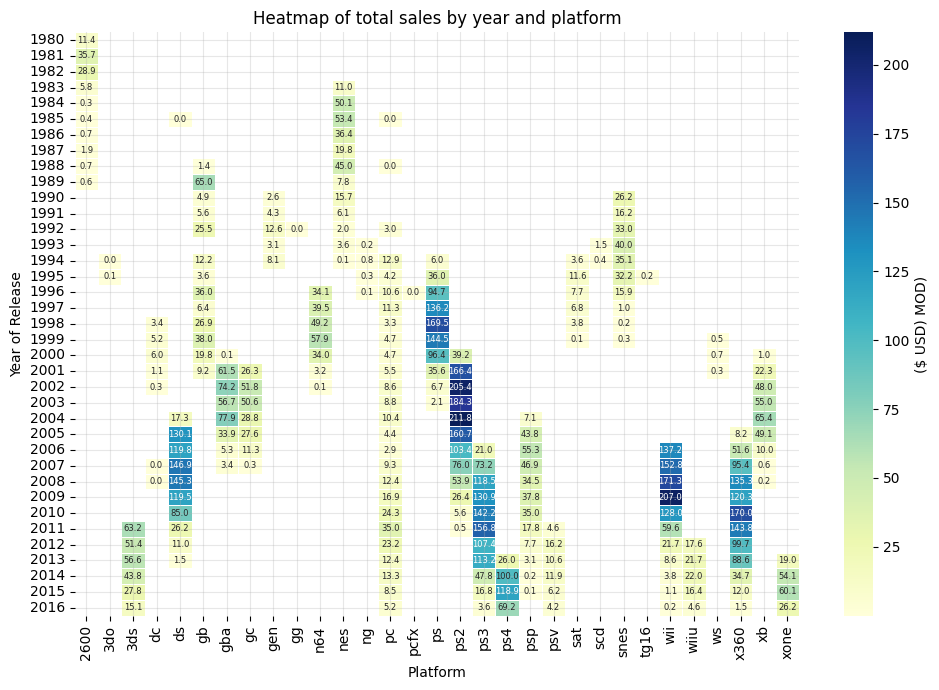

In [100]:
plt.figure(figsize=(10, 7))
sns.heatmap(ds_games_platform_year.unstack('platform'), cmap='YlGnBu', annot=True,
            fmt=".1f", annot_kws={"size": 6}, linewidths=0.5, cbar_kws={'label': '($ USD) MOD)'})
plt.title('Heatmap of total sales by year and platform')
plt.xlabel('Platform')
plt.ylabel('Year of Release')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

There is a marked trend in which video game sales experience a period of growth, followed by a progressive decline until consumption disappears over time.

##### _6.2.1_ Platforms that used to be popular

In [148]:
# Get total sales per year by platform
df_platform_year_sales = df_games.groupby(['platform', 'year_of_release'])[
    'total_sales'].sum().reset_index()
df_platform_year_sales

,platform,year_of_release,total_sales
0,2600,1980,11.38
1,2600,1981,35.68
2,2600,1982,28.88
3,2600,1983,5.84
4,2600,1984,0.27
...,...,...,...
233,xb,2008,0.18
234,xone,2013,18.96
235,xone,2014,54.07
236,xone,2015,60.14


In [149]:
# Get the latest years of video game sales by platform
df_last_sales_year = df_platform_year_sales.loc[(df_platform_year_sales['total_sales'] > 0), :].groupby(
    'platform')['year_of_release'].max().reset_index()
df_last_sales_year.columns = ['platform', 'last_year_sold']
df_last_sales_year

,platform,last_year_sold
0,2600,1989
1,3do,1995
2,3ds,2016
3,dc,2008
4,ds,2013
...,...,...
26,wiiu,2016
27,ws,2001
28,x360,2016
29,xb,2008


In [150]:
# Get the first years of video game sales by platform
df_first_sales_year = df_platform_year_sales.loc[(df_platform_year_sales['total_sales'] > 0), :].groupby(
    'platform')['year_of_release'].min().reset_index()
df_first_sales_year.columns = ['platform', 'first_year_sold']
df_first_sales_year

,platform,first_year_sold
0,2600,1980
1,3do,1994
2,3ds,2011
3,dc,1998
4,ds,1985
...,...,...
26,wiiu,2012
27,ws,1999
28,x360,2005
29,xb,2000


In [151]:
# Get the useful life of a platform
df_platform_lifespan = pd.merge(
    df_first_sales_year, df_last_sales_year, on='platform')
df_platform_lifespan['life_span'] = df_platform_lifespan['last_year_sold'] - \
    df_platform_lifespan['first_year_sold']
df_platform_lifespan = df_platform_lifespan.sort_values(
    'life_span', ascending=False)
df_platform_lifespan

,platform,first_year_sold,last_year_sold,life_span
13,pc,1985,2016,31
4,ds,1985,2013,28
5,gb,1988,2001,13
11,nes,1983,1994,11
28,x360,2005,2016,11
...,...,...,...,...
1,3do,1994,1995,1
22,scd,1993,1994,1
9,gg,1992,1992,0
14,pcfx,1996,1996,0


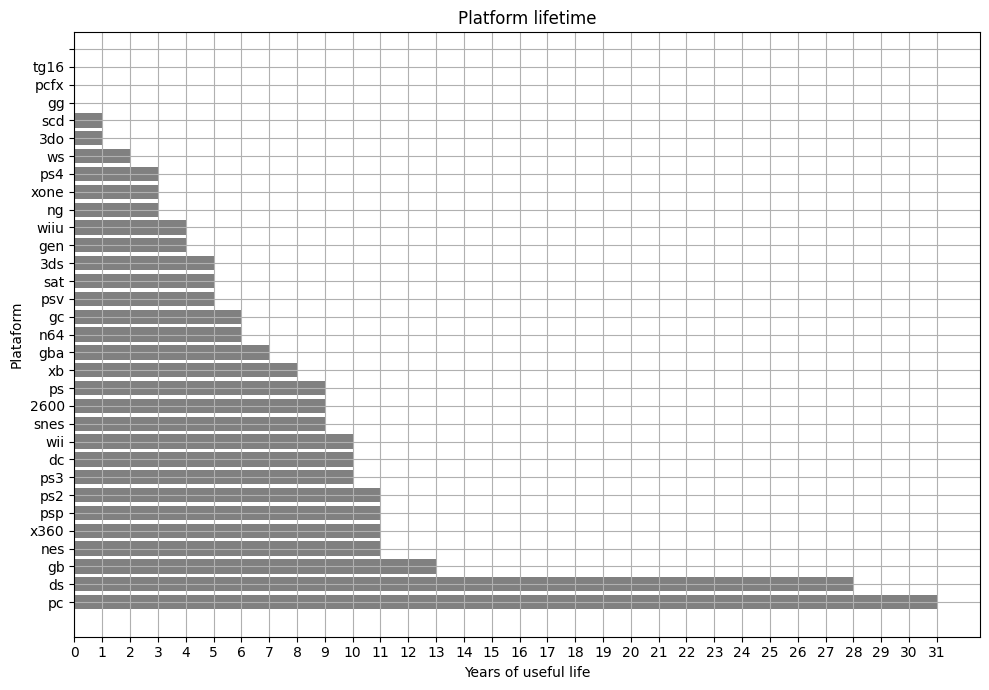

In [152]:
plt.figure(figsize=(10, 7))
plt.barh(df_platform_lifespan['platform'],
         df_platform_lifespan['life_span'], color='grey')
plt.title('Platform lifetime')
plt.xlabel('Years of useful life')
plt.ylabel('Plataform')
plt.grid(True)
plt.xticks(range(0, 32, 1), rotation=0)
plt.yticks(range(0, 32, 1), rotation=0)

plt.tight_layout()
plt.show()

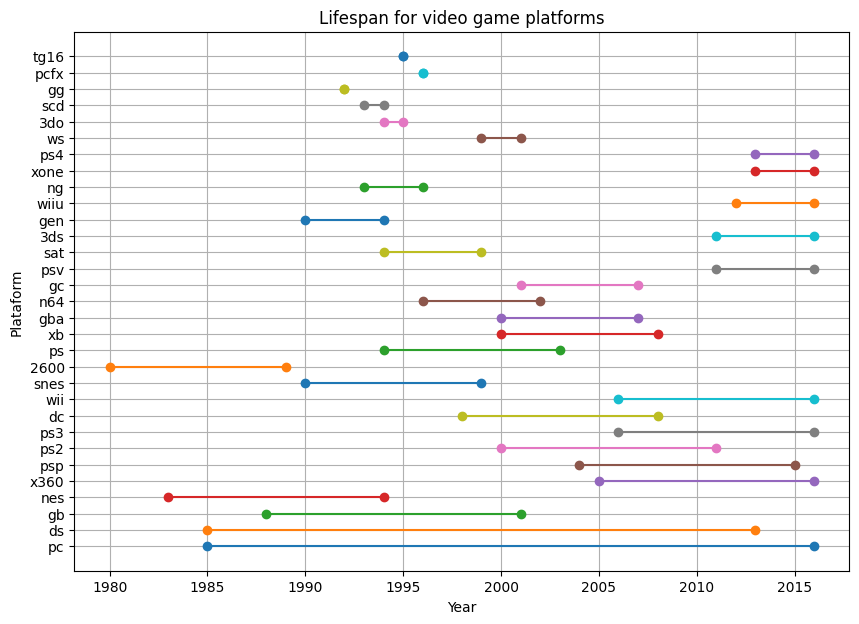

In [153]:
plt.figure(figsize=(10, 7))
for i, row in df_platform_lifespan.iterrows():
    plt.plot([row['first_year_sold'], row['last_year_sold']],
             [row['platform'], row['platform']], marker='o')

plt.title('Lifespan for video game platforms')
plt.xlabel('Year')
plt.ylabel('Plataform')
plt.grid(True)
plt.show()

##### _6.2.2_ Period of appearance and disappearance of platforms

In [154]:
merged_platforms = pd.merge(
    df_first_sales_year, df_last_sales_year, on='platform')
merged_platforms = merged_platforms.sort_values(
    'first_year_sold').reset_index(drop=True)
merged_platforms['gap_to_previous'] = merged_platforms['first_year_sold'].diff()
merged_platforms

,platform,first_year_sold,last_year_sold,gap_to_previous
0,2600,1980,1989,<NA>
1,nes,1983,1994,3
2,pc,1985,2016,2
3,ds,1985,2013,0
4,gb,1988,2001,3
...,...,...,...,...
26,3ds,2011,2016,5
27,psv,2011,2016,0
28,wiiu,2012,2016,1
29,ps4,2013,2016,1


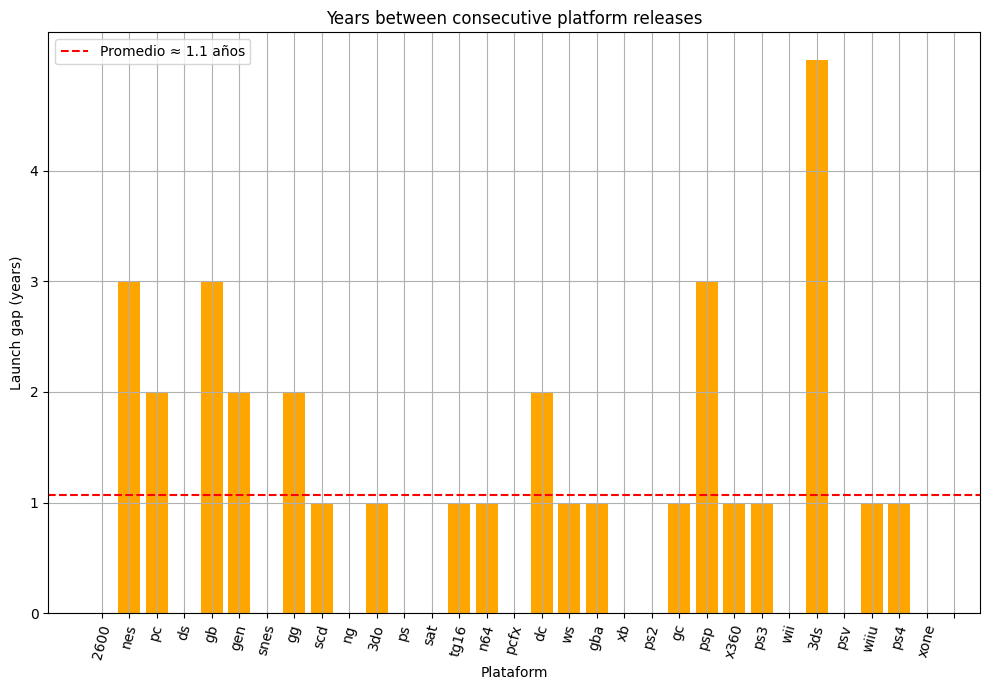

In [155]:
merged_platforms = merged_platforms.fillna(0)

avg_gap = merged_platforms['gap_to_previous'].mean()

plt.figure(figsize=(10, 7))
plt.bar(merged_platforms['platform'],
        merged_platforms['gap_to_previous'], color='orange')
plt.axhline(avg_gap, color='red', linestyle='--',
            label=f'Promedio ≈ {avg_gap:.1f} años')
plt.title('Years between consecutive platform releases')
plt.xlabel('Plataform')
plt.ylabel('Launch gap (years)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.xticks(range(0, 32, 1), rotation=75)
plt.yticks(range(0, 5, 1), rotation=0)
plt.tight_layout()
plt.show()

##### **6.3** Platform profitability

##### _6.3.1_ Total sales by platforms

In [156]:
# Leading sales platforms
ds_games_top_sales_platform = df_games.groupby(
    'platform')['total_sales'].sum().sort_values(ascending=False)
ds_games_top_sales_platform

platform
ps2     1255.77
x360     971.42
ps3      939.65
wii      907.51
ds       806.12
         ...   
ws         1.42
tg16       0.16
3do        0.10
gg         0.04
pcfx       0.03
Name: total_sales, Length: 31, dtype: float64

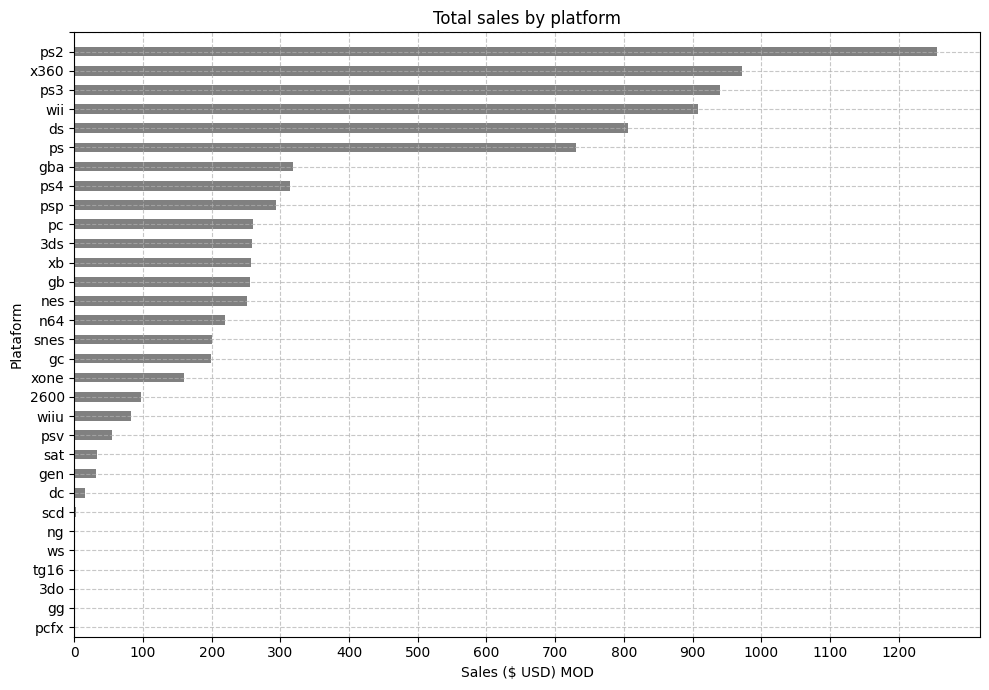

In [157]:
plt.figure(figsize=(10, 7))
ds_games_top_sales_platform.sort_values().plot(kind='barh', color='grey')

plt.title('Total sales by platform')
plt.xlabel('Sales ($ USD) MOD')
plt.ylabel('Plataform')
plt.xticks(range(0, 1300, 100), rotation=0)
plt.yticks(range(0, 32, 1), rotation=0)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### _6.3.2_ Potentially profitable platforms

In [158]:
# Average scores per platform
df_score_avg = df_games.groupby(
    'platform')[['norm_critic_score', 'user_score']].mean()
df_score_avg['quality_factor'] = (
    df_score_avg['norm_critic_score'] + df_score_avg['user_score']) / 2
df_score_avg

,norm_critic_score,user_score,quality_factor
platform,,,
2600,6.788494,7.015406,6.90195
3do,6.661433,7.071667,6.86655
3ds,6.806325,6.980467,6.893396
dc,7.330413,7.464404,7.397409
ds,6.595725,6.995496,6.79561
...,...,...,...
wiiu,7.011626,6.992585,7.002105
ws,7.259767,7.524333,7.39205
x360,6.872461,6.729945,6.801203


In [159]:
# Number of games per platform
ds_game_counts = game_counts = df_games['platform'].value_counts()
ds_game_counts

platform
ps2     2161
ds      2151
ps3     1331
wii     1320
x360    1262
        ... 
ws         6
3do        3
tg16       2
gg         1
pcfx       1
Name: count, Length: 31, dtype: int64

In [160]:
# Average game sales
ds_sales_per_game = ds_games_top_sales_platform / ds_game_counts
ds_sales_per_game

platform
2600    0.729173
3do     0.033333
3ds     0.498077
dc      0.306731
ds      0.374765
          ...   
wiiu    0.559116
ws      0.236667
x360    0.769746
xb      0.312791
xone    0.645020
Length: 31, dtype: float64

In [161]:
# Dataframe generation to analyze the profitability of each platform
df_games_profit_platform = df_platform_lifespan.copy()
df_games_profit_platform['life_span'] = df_games_profit_platform['life_span'].replace(
    0, np.nan)
df_games_profit_platform['total_sales'] = df_games_profit_platform['platform'].map(
    ds_games_top_sales_platform)
df_games_profit_platform['sales_per_year'] = df_games_profit_platform['total_sales'] / \
    df_games_profit_platform['life_span']
df_games_profit_platform

,platform,first_year_sold,last_year_sold,life_span,total_sales,sales_per_year
13,pc,1985,2016,31,259.52,8.371613
4,ds,1985,2013,28,806.12,28.79
5,gb,1988,2001,13,255.46,19.650769
11,nes,1983,1994,11,251.05,22.822727
28,x360,2005,2016,11,971.42,88.310909
...,...,...,...,...,...,...
1,3do,1994,1995,1,0.10,0.1
22,scd,1993,1994,1,1.86,1.86
9,gg,1992,1992,<NA>,0.04,<NA>
14,pcfx,1996,1996,<NA>,0.03,<NA>


In [162]:
# Feature engineering for platform profitability dataframe
df_games_profit_platform['mean_score'] = df_games_profit_platform['platform'].map(
    df_score_avg['quality_factor'])
df_games_profit_platform['games_count'] = df_games_profit_platform['platform'].map(
    ds_game_counts)
df_games_profit_platform['sales_per_game'] = df_games_profit_platform['platform'].map(
    ds_sales_per_game)
df_games_profit_platform

,platform,first_year_sold,last_year_sold,life_span,total_sales,sales_per_year,mean_score,games_count,sales_per_game
13,pc,1985,2016,31,259.52,8.371613,7.24984,974,0.266448
4,ds,1985,2013,28,806.12,28.79,6.79561,2151,0.374765
5,gb,1988,2001,13,255.46,19.650769,7.112976,98,2.606735
11,nes,1983,1994,11,251.05,22.822727,7.022506,98,2.561735
28,x360,2005,2016,11,971.42,88.310909,6.801203,1262,0.769746
...,...,...,...,...,...,...,...,...,...
1,3do,1994,1995,1,0.10,0.1,6.86655,3,0.033333
22,scd,1993,1994,1,1.86,1.86,6.996833,6,0.310000
9,gg,1992,1992,<NA>,0.04,<NA>,6.98235,1,0.040000
14,pcfx,1996,1996,<NA>,0.03,<NA>,7.4672,1,0.030000


In [163]:
# Generation of platform profitability metrics
df_games_profit_platform['adjusted_profitability'] = ((df_games_profit_platform['total_sales'] / df_games_profit_platform['life_span']) *
                                                      df_games_profit_platform['mean_score'] * df_games_profit_platform['sales_per_game'])
df_games_profit_platform = df_games_profit_platform.dropna()
df_games_profit_platform

,platform,first_year_sold,last_year_sold,life_span,total_sales,sales_per_year,mean_score,games_count,sales_per_game,adjusted_profitability
13,pc,1985,2016,31,259.52,8.371613,7.24984,974,0.266448,16.171467
4,ds,1985,2013,28,806.12,28.79,6.79561,2151,0.374765,73.321175
5,gb,1988,2001,13,255.46,19.650769,7.112976,98,2.606735,364.357516
11,nes,1983,1994,11,251.05,22.822727,7.022506,98,2.561735,410.576244
28,x360,2005,2016,11,971.42,88.310909,6.801203,1262,0.769746,462.325401
...,...,...,...,...,...,...,...,...,...,...
30,xone,2013,2016,3,159.32,53.106667,6.972354,247,0.645020,238.837116
18,ps4,2013,2016,3,314.14,104.713333,7.021347,392,0.801378,589.195719
27,ws,1999,2001,2,1.42,0.71,7.39205,6,0.236667,1.242111
1,3do,1994,1995,1,0.10,0.1,6.86655,3,0.033333,0.022888


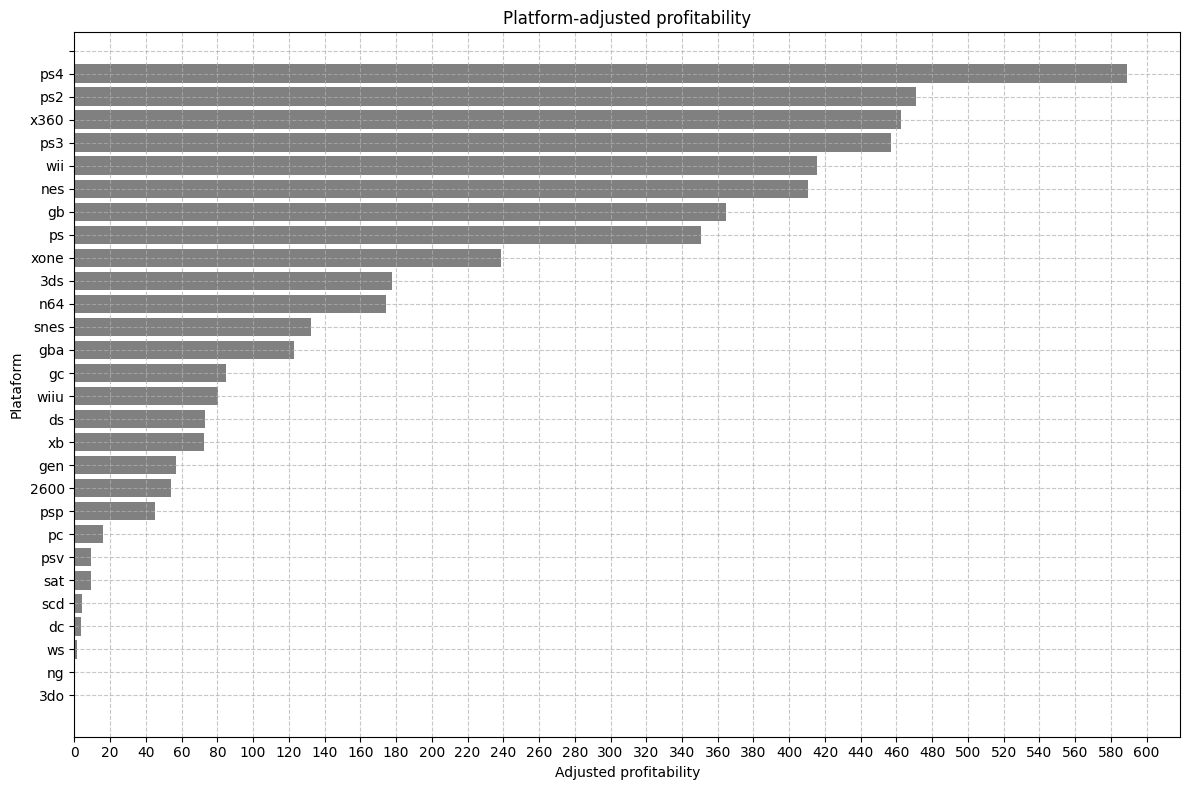

In [164]:
df_sorted = df_games_profit_platform.sort_values(
    'adjusted_profitability', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(df_sorted['platform'],
         df_sorted['adjusted_profitability'], color='grey')
plt.title('Platform-adjusted profitability')
plt.xlabel('Adjusted profitability')
plt.ylabel('Plataform')
plt.xticks(range(0, 610, 20), rotation=0)
plt.yticks(range(0, 29, 1), rotation=0)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

The adjusted profitability metric generated for each platform is a relative and comparative metric that reflects a solid idea of:

- Average annual sales.
- Highly rated sales (by users/critics).
- Game success (sales per game).

The higher the value, the more profitable and efficient the platform was in relation to its time, its perceived quality, and the efficiency of its catalog. This is how the internal ranking of platforms is obtained.

##### _6.3.3_ Global video game sales broken down by platform

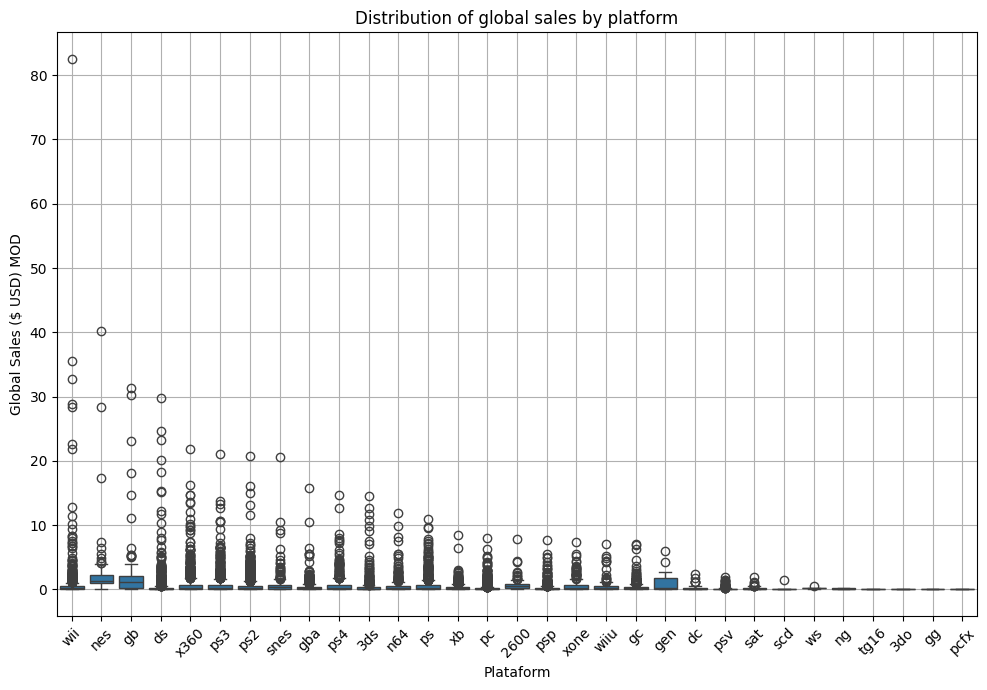

In [165]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_games, x='platform', y='total_sales')

plt.title('Distribution of global sales by platform')
plt.xlabel('Plataform')
plt.ylabel('Global Sales ($ USD) MOD')
plt.xticks(rotation=45)
plt.yticks(range(0, 90, 10), rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

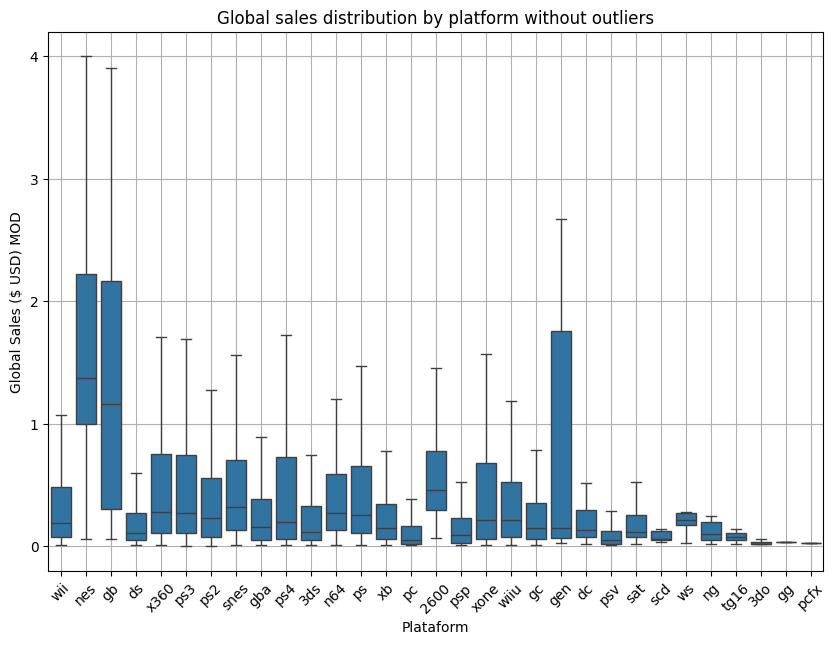

In [166]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_games, x='platform', y='total_sales', showfliers=False)
plt.title('Global sales distribution by platform without outliers')
plt.xlabel('Plataform')
plt.ylabel('Global Sales ($ USD) MOD')
plt.xticks(rotation=45)
plt.yticks(range(0, 5, 1), rotation=0)
plt.grid(True)

##### `LSPL`

**_Note_:**

The box plot shows clear differences in the distribution of global sales across platforms. Some, such as the Wii, NES, GB, and GEN, show a high dispersion, indicating the presence of highly successful titles. The graph excluding outliers shows that most platforms have median sales under $1 million, suggesting that the best-selling games are the exception rather than the rule. This reinforces the typical pattern in the video game market, where a few titles account for a large portion of total sales.


##### _6.3.4_ Comparison of video game sales on different platforms

In [167]:
platforms = df_games['platform'].unique()
display(HTML(
    f"> Plataformas: <b>{df_games['platform'].nunique()}</b> <br>{df_games['platform'].unique()}"))

In [168]:
videogames = df_games['name'].unique()
display(HTML(
    f"> Videojuegos: <b>{df_games['name'].nunique()}</b> <br>{df_games['name'].unique()}"))

In [169]:
# Video game sales on different platforms
df_games_multiplatform = df_games.groupby(['name', 'platform'])[
    'total_sales'].sum().round(2).reset_index()
df_games_multiplatform

,name,platform,total_sales
0,007_quantum_of_solace,ds,0.13
1,007_quantum_of_solace,pc,0.02
2,007_quantum_of_solace,ps2,0.43
3,007_quantum_of_solace,ps3,1.15
4,007_quantum_of_solace,wii,0.65
...,...,...,...
16703,zumba_fitness_rush,x360,0.18
16704,zumba_fitness_world_party,wii,0.23
16705,zumba_fitness_world_party,xone,0.24
16706,zwei_,psp,0.02


In [170]:
# Detection of video games that are sold on more than one platform
multi_platform_games = df_games['name'].value_counts()
multi_platform_games

name
need_for_speed_most_wanted                                  12
lego_marvel_super_heroes                                     9
madden_nfl_07                                                9
fifa_14                                                      9
ratatouille                                                  9
                                                            ..
storm_frontline_nation                                       1
7_scarlet                                                    1
help_wanted_50_wacky_jobs_jp_sales_                          1
yattaman_wii_bikkuridokkiri_machine_de_mou_race_da_koron     1
neo_angelique_special                                        1
Name: count, Length: 11533, dtype: int64

In [171]:
multi_platform_games = multi_platform_games[multi_platform_games > 1].index
multi_platform_games

Index(['need_for_speed_most_wanted', 'lego_marvel_super_heroes', 'madden_nfl_07', 'fifa_14', 'ratatouille', 'monopoly',
       'lego_batman_3_beyond_gotham', 'lego_jurassic_world', 'lego_the_hobbit', 'terraria',
       ...
       'sakura_wars_so_long_my_love', 'micro_machines_v4', 'rocksmith_2014_edition_remastered', 'kao_the_kangaroo_round_2', 'nba_street_homecourt',
       'tony_hawk_s_american_sk8land', 'rooms_the_main_building', 'mystery_dungeon_shiren_the_wanderer', 'uefa_euro_2016',
       'winning_post_7_maximum_2008'],
      dtype='object', name='name', length=2818)

In [172]:
df_multi_platform_sales = df_games[df_games['name'].isin(multi_platform_games)]
df_multi_platform_sales

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,game_age,norm_critic_score,mean_score,score_gap,platform_count
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,67.337,7.231,unknown,40.24,40,6.7337,6.98235,0.4973,2
5,tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,67.293,7.088,unknown,30.26,36,6.7293,6.90865,0.3587,2
16,grand_theft_auto_v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,12,9.7,8.95,1.5,5
17,grand_theft_auto_san_andreas,ps2,2004,action,9.43,0.40,0.41,10.57,95.0,9.0,M,20.81,21,9.5,9.25,0.5,4
18,super_mario_world,snes,1990,platform,12.78,3.75,3.54,0.55,67.337,7.231,unknown,20.62,35,6.7337,6.98235,0.4973,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16706,men_in_black_ii_alien_escape,gc,2003,shooter,0.01,0.00,0.00,0.00,50.0,7.3,T,0.01,22,5.0,6.15,2.3,2
16709,score_international_baja_1000_the_official_game,ps2,2008,racing,0.00,0.00,0.00,0.00,67.584,6.998,unknown,0.00,17,6.7584,6.8782,0.2396,4
16710,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,66.893,7.022,unknown,0.01,9,6.6893,6.85565,0.3327,3
16713,spirits_spells,gba,2003,platform,0.01,0.00,0.00,0.00,67.337,7.231,unknown,0.01,22,6.7337,6.98235,0.4973,2


In [173]:
pivot = df_multi_platform_sales.pivot_table(
    index='name', columns='platform', values='total_sales', fill_value=0)
pivot

platform,2600,3ds,dc,ds,gb,gba,gc,gen,n64,nes,ng,pc,...,ps3,ps4,psp,psv,sat,snes,wii,wiiu,ws,x360,xb,xone
name,,,,,,,,,,,,,,,,,,,,,,,,,
007_quantum_of_solace,0.0,0.0,0.0,0.13,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.02,...,1.15,0.0,0.00,0.0,0.0,0.0,0.65,0.0,0.0,1.48,0.00,0.00
007_the_world_is_not_enough,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,1.56,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
11eyes_crossover,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.00,0.00
187_ride_or_die,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.06,0.00
18_wheeler_american_pro_trucker,0.0,0.0,0.0,0.00,0.0,0.00,0.11,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoo_tycoon_2013_,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.09,0.00,0.36
zoocube,0.0,0.0,0.0,0.00,0.0,0.04,0.02,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
zumba_fitness,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.57,0.0,0.00,0.0,0.0,0.0,6.70,0.0,0.0,2.37,0.00,0.00


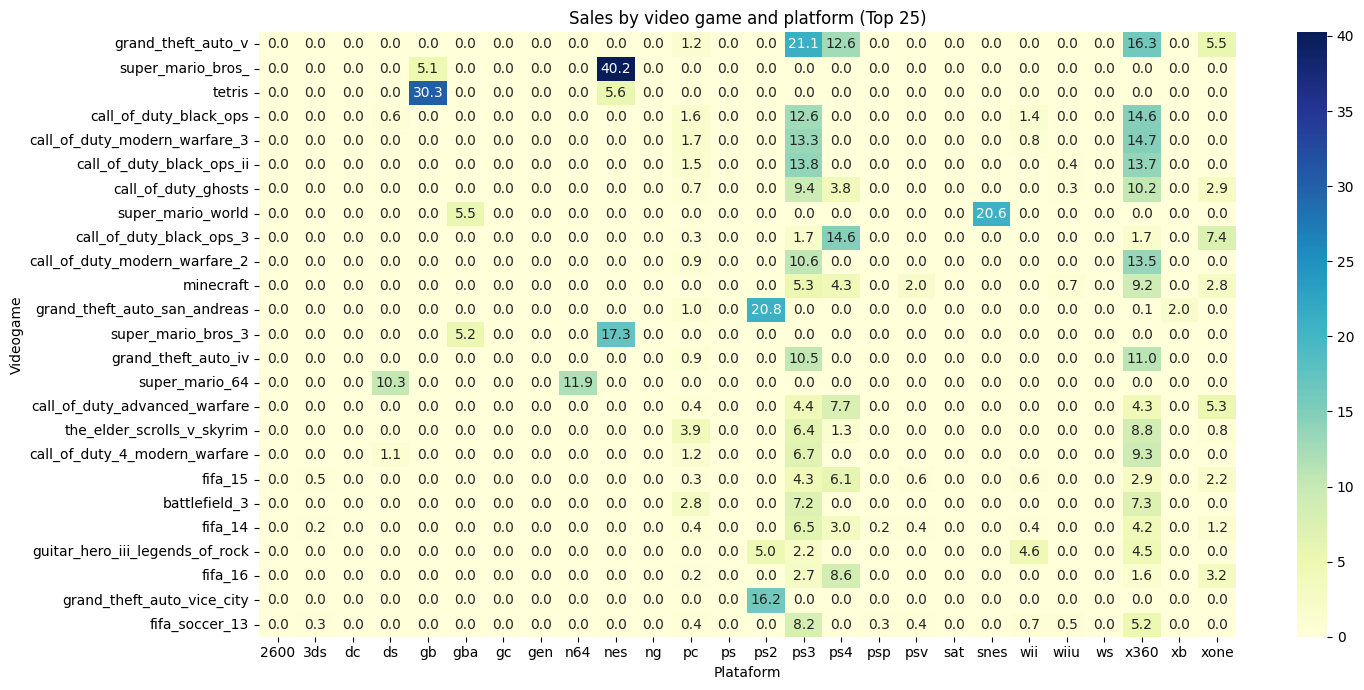

In [174]:
top25_games = df_multi_platform_sales.groupby(
    'name')['total_sales'].sum().sort_values(ascending=False).head(25).index
pivot_top25 = pivot.loc[top25_games]

plt.figure(figsize=(15, 7))
sns.heatmap(pivot_top25, annot=True, fmt=".1f", cmap='YlGnBu')

plt.title('Sales by video game and platform (Top 25)')
plt.xlabel('Plataform')
plt.ylabel('Videogame')
plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

Some video games have been strongly dominant on a single platform, while others have had a more balanced sales distribution across multiple systems.

There are few games that demonstrate a clearly effective multiplatform strategy. Others appear on more than five platforms with more moderate values, which could reflect later ports that do not achieve the same impact on all of them.

Few games concentrate the majority of sales, and they usually do so on one or two key platforms.


##### **6.4** Distribution of games by genre

##### _6.4.1_ Gender profitability

In [175]:
# Most profitable genres
ds_games_profitable_genres = df_games.groupby(
    'genre')['total_sales'].sum().round(3)
ds_games_profitable_genres

genre
action          1744.17
adventure        237.59
fighting         447.53
misc             802.51
platform         827.77
puzzle           242.57
racing           728.67
role_playing     934.56
shooter         1052.45
simulation       389.97
sports          1331.27
strategy         174.23
unknown            2.42
Name: total_sales, dtype: float64

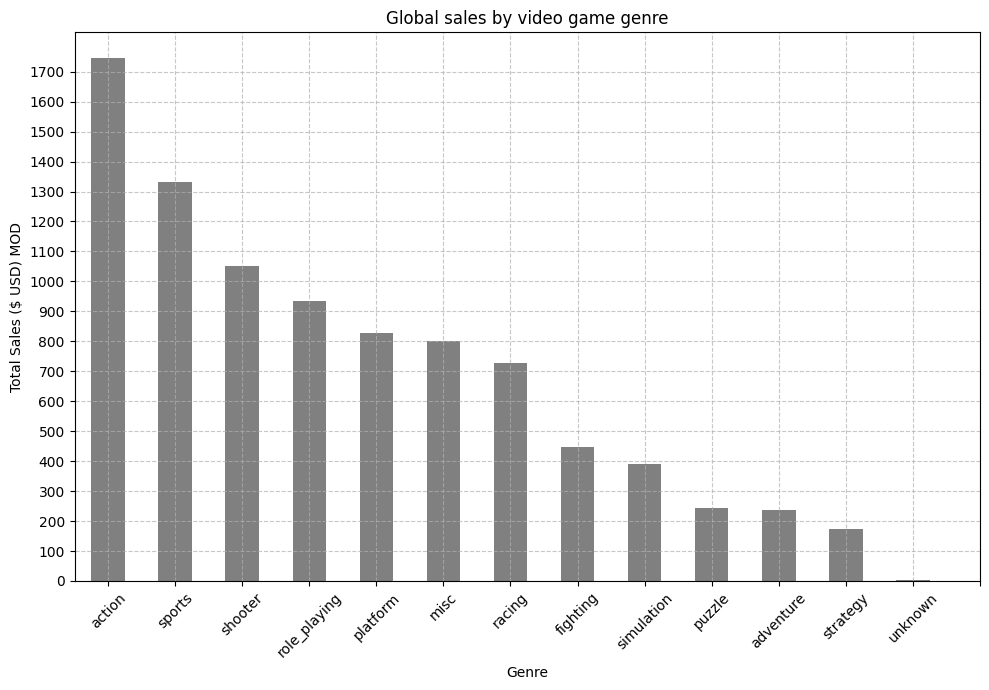

In [176]:
plt.figure(figsize=(10, 7))
ds_games_profitable_genres.sort_values(
    ascending=False).plot(kind='bar', color='grey')

plt.title('Global sales by video game genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales ($ USD) MOD')

plt.xticks(range(0, 14, 1), rotation=45)
plt.yticks(range(0, 1755, 100), rotation=0)
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

##### _6.4.2_ Sales diversity by gender

##### `LSPL`

**_Note_:**

When analyzing global sales by genre, it can be seen that certain genres tend to consistently generate higher revenues.
The highest-selling genres are usually the most popular and have a greater cross-platform presence. On the other hand, the lowest-selling genres, although some have notable titles, tend to have fewer major releases and lower sales per game. This may be due to a smaller market niche or lower investment in marketing and distribution.

In general, high-performing genres tend to be associated with multiplayer, sports, or fast-paced action experiences, while lower-performing genres tend to focus on more narrative-driven or niche experiences, which limits their global commercial reach.

##### **6.5** Profiles per region

##### *6.5.1* Profile for the North American region

In [ ]:
# Five main platforms
ds_top5_platform_na = df_games.groupby(
    'platform')['na_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_platform_na

platform
x360    602.47
ps2     583.84
wii     496.90
ps3     393.49
ds      382.40
Name: na_sales, dtype: float64

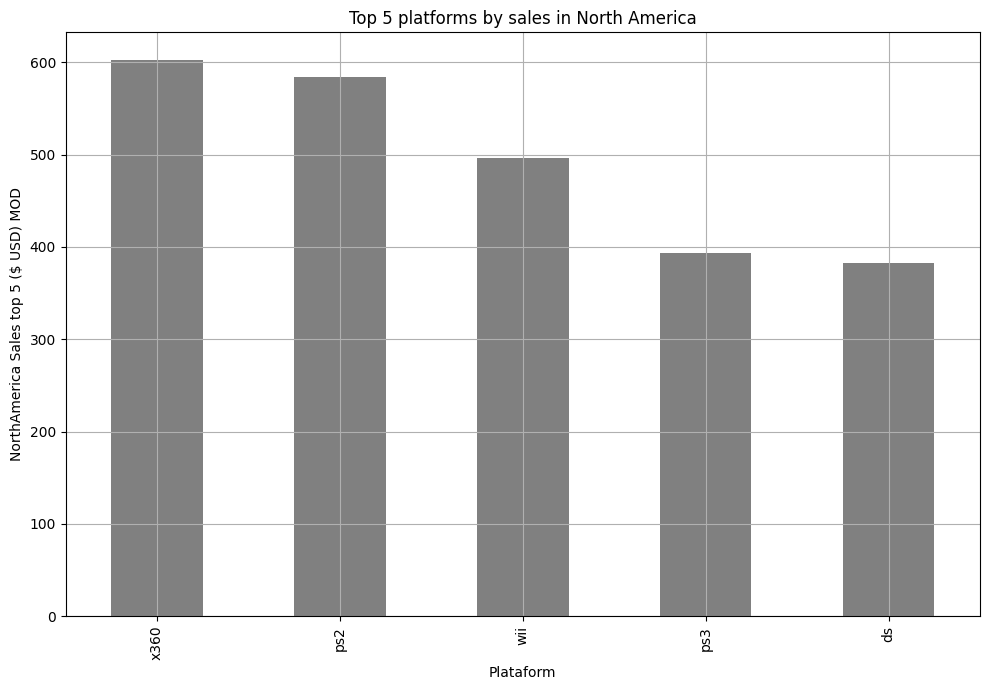

In [178]:
plt.figure(figsize=(10, 7))
ds_top5_platform_na.plot(
    kind='bar', title='Top 5 platforms by sales in North America', color='grey')
plt.ylabel('NorthAmerica Sales top 5 ($ USD) MOD')
plt.xlabel('Plataform')
plt.grid()
plt.tight_layout()
plt.show()

In [179]:
# Five main genres
ds_top5_genre_na = df_games.groupby(
    'genre')['na_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_genre_na

genre
action      879.01
sports      684.43
shooter     592.24
platform    445.50
misc        407.27
Name: na_sales, dtype: float64

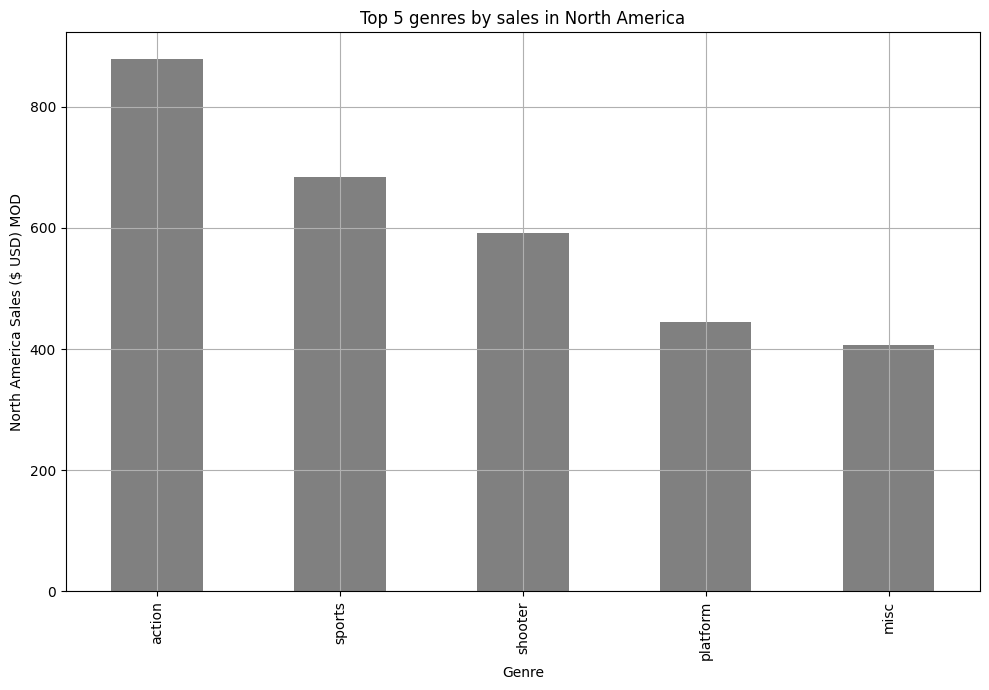

In [180]:
plt.figure(figsize=(10, 7))
ds_top5_genre_na.plot(
    kind='bar', title='Top 5 genres by sales in North America', color='grey')
plt.ylabel('North America Sales ($ USD) MOD')
plt.xlabel('Genre')
plt.grid()
plt.tight_layout()
plt.show()

##### *6.5.2* Profile for the European Union region

In [ ]:
# Five main platforms
ds_top5_platform_eu = df_games.groupby(
    'platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_platform_eu

platform
ps2     339.29
ps3     330.29
x360    270.76
wii     262.21
ps      213.61
Name: eu_sales, dtype: float64

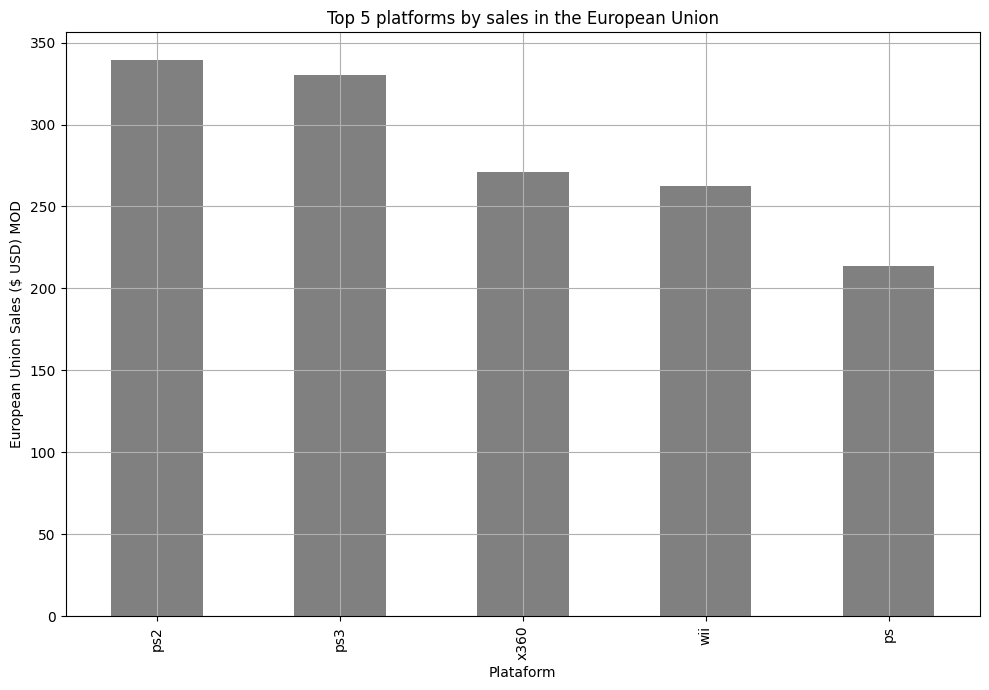

In [182]:
plt.figure(figsize=(10, 7))
ds_top5_platform_eu.plot(
    kind='bar', title='Top 5 platforms by sales in the European Union', color='grey')
plt.ylabel('European Union Sales ($ USD) MOD')
plt.xlabel('Plataform')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Five main genres
ds_top5_genre_eu = df_games.groupby(
    'genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_genre_eu

genre
action     519.13
sports     376.79
shooter    317.34
racing     236.51
misc       212.74
Name: eu_sales, dtype: float64

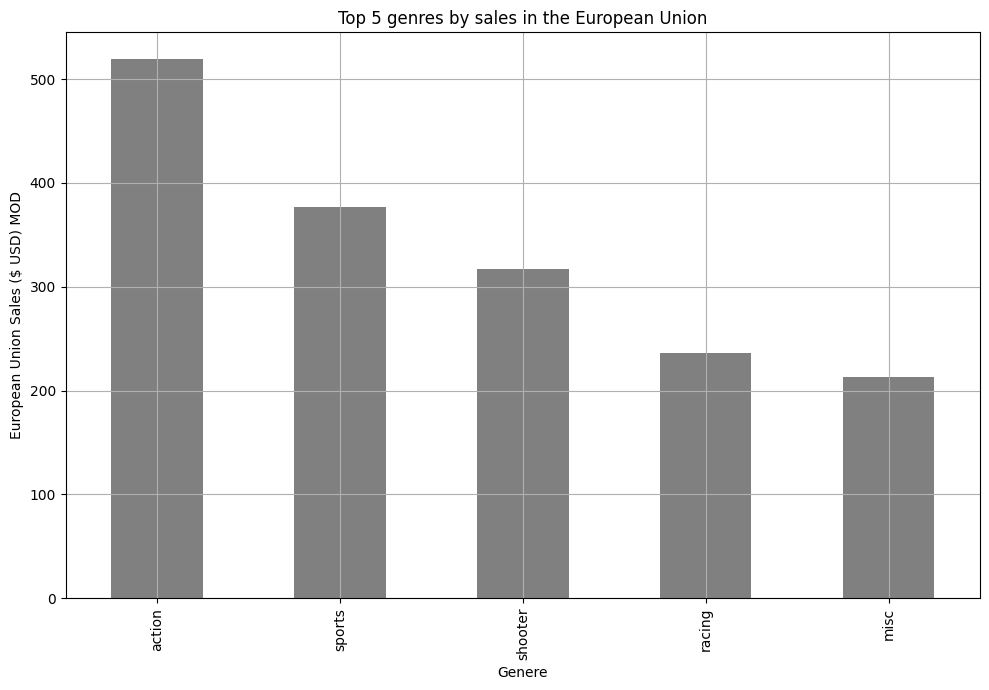

In [184]:
plt.figure(figsize=(10, 7))
ds_top5_genre_eu.plot(
    kind='bar', title='Top 5 genres by sales in the European Union', color='grey')
plt.ylabel('European Union Sales ($ USD) MOD')
plt.xlabel('Genere')
plt.grid()
plt.tight_layout()
plt.show()

##### *6.5.3* Profile for the Japan region

In [185]:
# Cinco plataformas principales
ds_top5_platform_jp = df_games.groupby(
    'platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_platform_jp

platform
ds      175.57
ps      139.82
ps2     139.20
snes    116.55
3ds     100.67
Name: jp_sales, dtype: float64

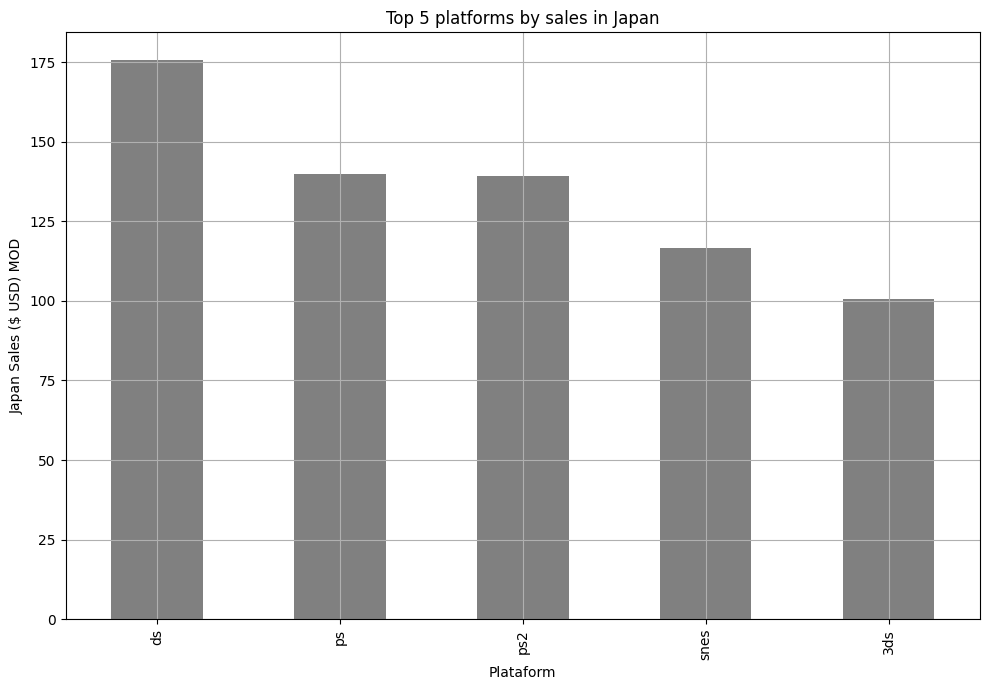

In [186]:
plt.figure(figsize=(10, 7))
ds_top5_platform_jp.plot(
    kind='bar', title='Top 5 platforms by sales in Japan', color='grey')
plt.ylabel('Japan Sales ($ USD) MOD')
plt.xlabel('Plataform')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Five main genres
ds_top5_genre_jp = df_games.groupby(
    'genre')['jp_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_genre_jp

genre
role_playing    355.41
action          161.43
sports          135.54
platform        130.83
misc            108.11
Name: jp_sales, dtype: float64

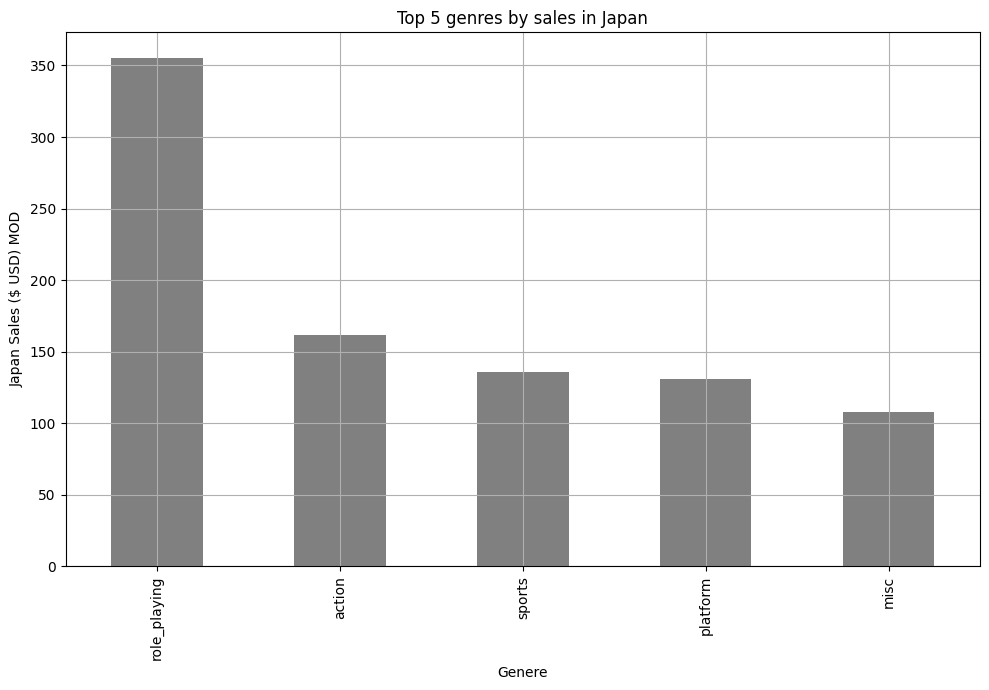

In [188]:
plt.figure(figsize=(10, 7))
ds_top5_genre_jp.plot(
    kind='bar', title='Top 5 genres by sales in Japan', color='grey')
plt.ylabel('Japan Sales ($ USD) MOD')
plt.xlabel('Genere')
plt.grid()
plt.tight_layout()
plt.show()

##### *6.5.4* Profile for the Other part of the world region

In [ ]:
# Five main platforms
ds_top5_platform_other = df_games.groupby(
    'platform')['other_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_platform_other

platform
ps2     193.44
ps3     135.68
x360     85.76
wii      79.07
ds       59.26
Name: other_sales, dtype: float64

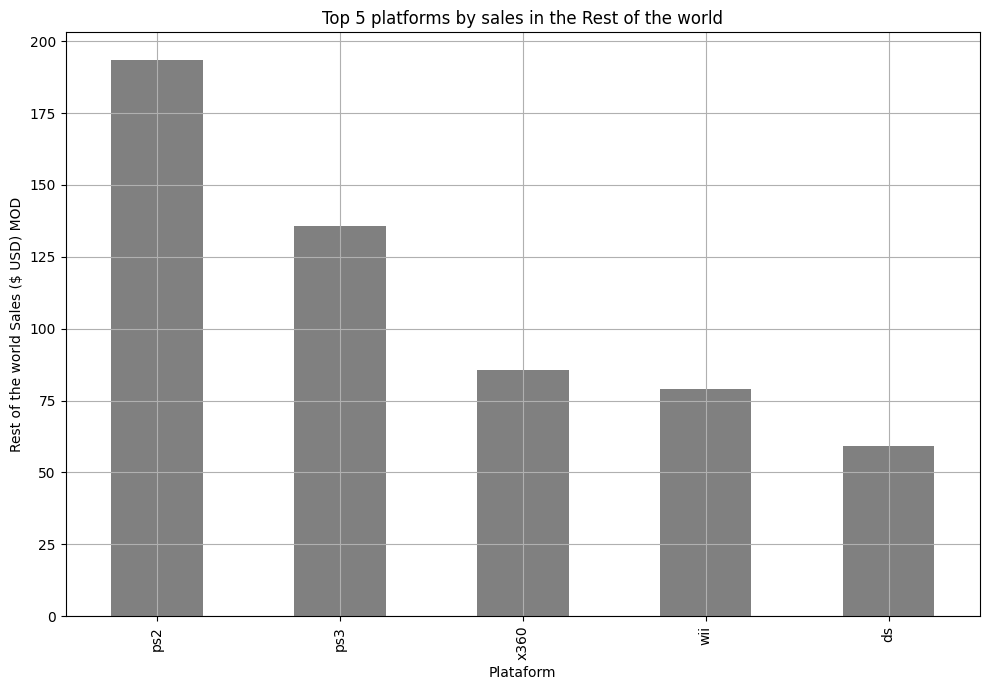

In [190]:
plt.figure(figsize=(10, 7))
ds_top5_platform_other.plot(
    kind='bar', title='Top 5 platforms by sales in the Rest of the world', color='grey')
plt.ylabel('Rest of the world Sales ($ USD) MOD')
plt.xlabel('Plataform')
plt.grid()
plt.tight_layout()
plt.show()

In [191]:
# Five main genres
ds_top5_genre_other = df_games.groupby(
    'genre')['other_sales'].sum().sort_values(ascending=False).head(5)
ds_top5_genre_other

genre
action     184.60
sports     134.51
shooter    104.11
racing      76.10
misc        74.39
Name: other_sales, dtype: float64

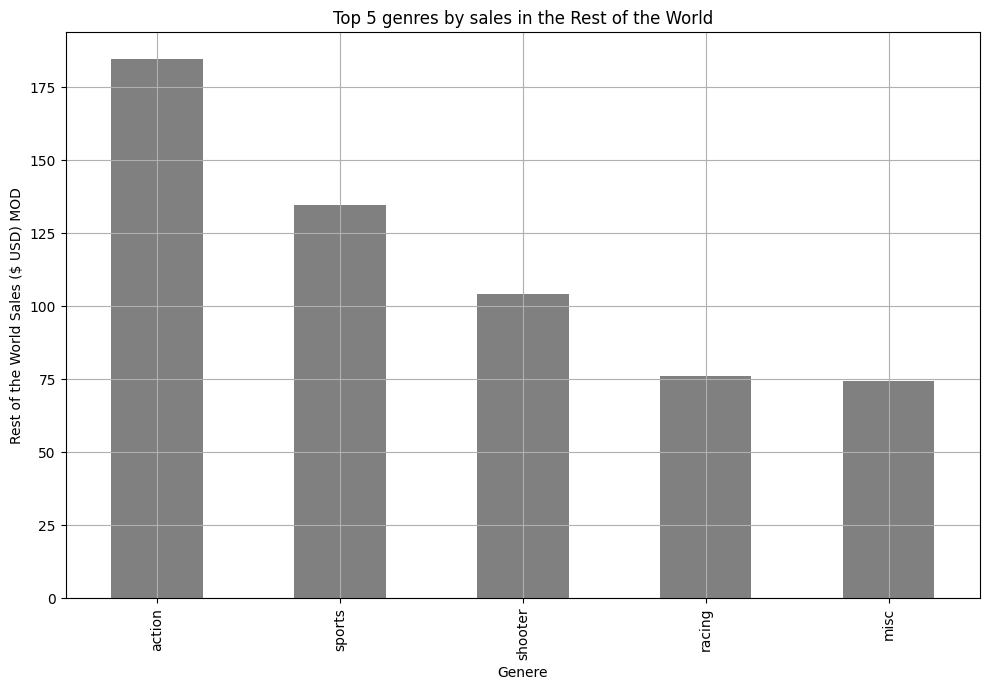

In [192]:
plt.figure(figsize=(10, 7))
ds_top5_genre_other.plot(
    kind='bar', title='Top 5 genres by sales in the Rest of the World', color='grey')
plt.ylabel('Rest of the World Sales ($ USD) MOD')
plt.xlabel('Genere')
plt.grid()
plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

- Main platform trends by region:

| Region | Dominance | Main platforms | Comments |
| --------------- | ------------------ | ----------------------- | ------------------------------------------------ |
| North America | Xbox + PlayStation | X360, PS2, Wii | Microsoft is strong; Nintendo is well positioned |
| Europe | PlayStation | PS2, PS3, X360 | Preference for Sony consoles |
| Japan | Nintendo + Sony | DS, PS, SNES | Microsoft absent; strong national identity |
| Rest of the world | Sony dominant | PS2, PS3, X360 | More balanced, but with clear Sony leadership |

- Difference in trend by genre:

| Region | Best-selling genre | Comments |
| --------------- | ------------------ | ----------------------------------------------- |
| North America | Action | High affinity for shooters and sports games |
| Europe | Action | Action, racing, and sports dominate |
| Japan | Role-Playing | RPG dominance; shooters absent |
| Rest of the world | Action | Western model: action, sports, and shooters |



##### *6.5.5* Rating influence on individual regions

In [193]:
ratings_sales = df_games.groupby(
    'rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
ratings_sales

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
AO,1.26,0.61,0.00,0.09
E,1292.99,710.25,198.11,234.17
E10+,353.32,188.52,40.20,73.56
EC,1.53,0.11,0.00,0.11
K-A,2.56,0.27,1.46,0.03
M,748.48,483.97,64.24,177.10
RP,0.00,0.08,0.00,0.01
T,759.75,427.03,151.40,155.17
unknown,1242.46,613.83,841.96,151.08


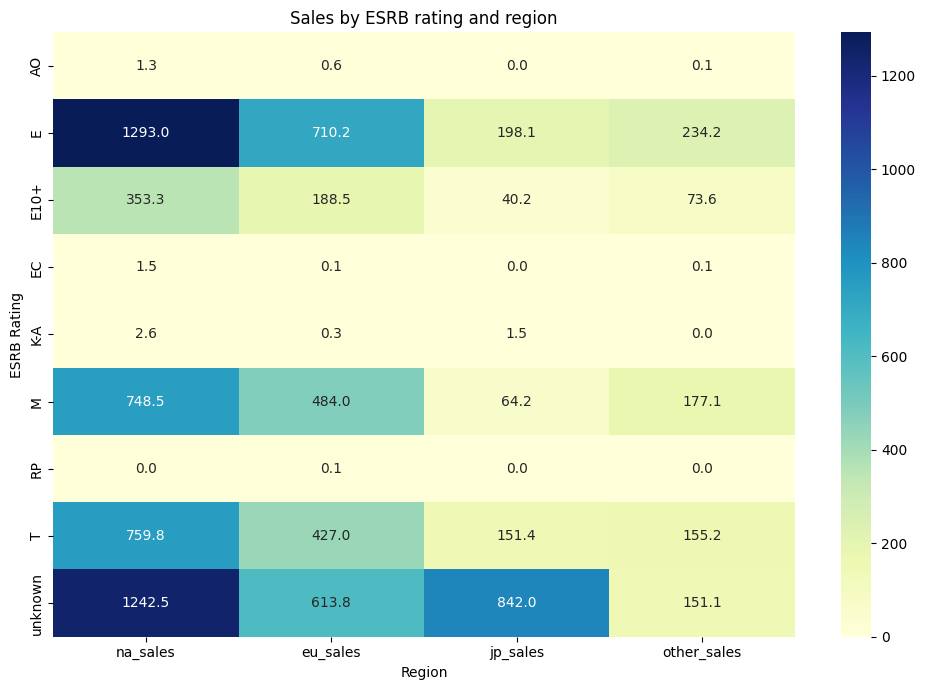

In [194]:

plt.figure(figsize=(10, 7))
sns.heatmap(ratings_sales, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Sales by ESRB rating and region')
plt.xlabel('Region')
plt.ylabel('ESRB Rating')
plt.tight_layout()
plt.show()

| **Rating** | **Meaning** | **Age suggestion** | **Description** |
| ---------- | --------------------- | ----------------- | -------------------------------------------------------------------------------------------------- |
| **EC** | Early Childhood | 3+ years | Educational games for young children. No objectionable content. |
| **E** | Everyone | 6+ years | Suitable for all audiences: cartoonish, mild violence, or minimal language. |
| **E10+** | Everyone 10 and older | 10+ years | May contain milder cartoon violence, mild language, or minimally suggestive themes. |
| **T** | Teen | 13+ years | Moderate violence, somewhat strong language, or suggestive themes. |
| **M** | Mature | 17+ years | Intense violence, blood, strong language, or mild sexual content. |
| **AO** | Adults Only | 18+ years | Explicit sexual content or extreme graphic violence. Very rare on the market. |
| **RP** | Rating Pending | N/A | Game not yet officially rated by the ESRB. Used in demos or promotions. |


##### `LSPL`

**_Note_:**

While E-rated games (Everyone) account for the majority of global sales, the rating does have a regional impact, especially in genres geared toward teens or adults.
In North America and Europe, T and M games have high sales, reflecting solid demand for titles with more mature content.
In Japan, the trend is different: the high volume under Unknown and lower sales under M suggest a different preference or lack of ESRB data on local titles.

### 🧪 __7. Evaluation__

##### **7.1** Hypothesis: "The average user ratings for the Xbox One and PC platforms are the same."

In [195]:
print(df_games.loc[(df_games['platform'] == 'xone'), 'user_score'].describe())

count       247.0
mean     6.671571
std       1.26861
min           1.6
25%           6.0
50%         6.998
75%           7.5
max           9.2
Name: user_score, dtype: Float64


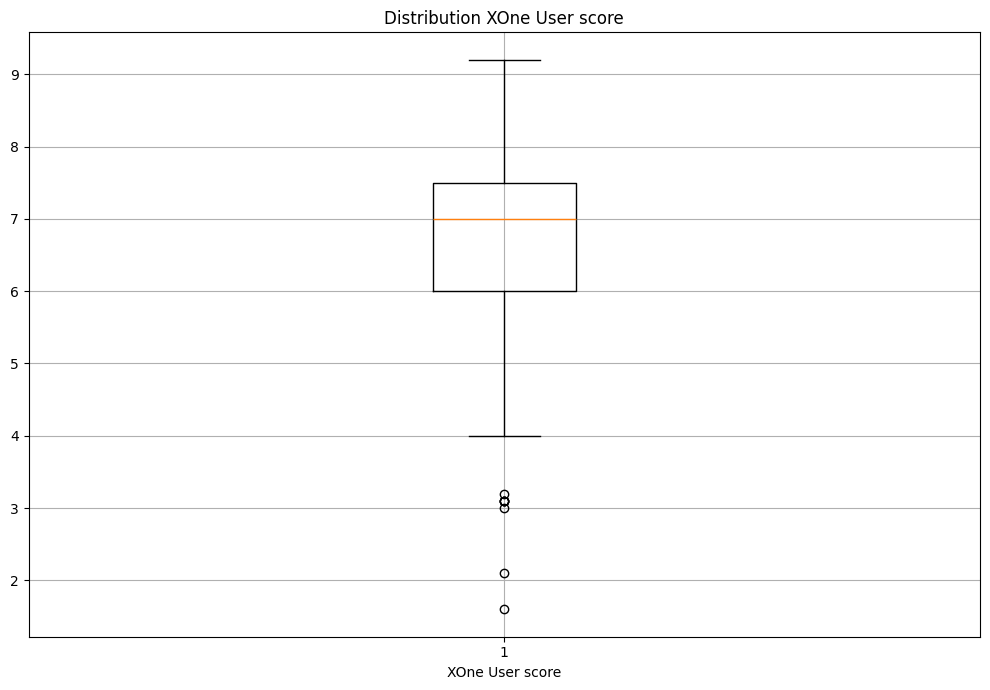

In [196]:
df_xone = df_games.loc[(df_games['platform'] == 'xone'),
                       'user_score'].reset_index(drop=True).to_frame()
plt.figure(figsize=(10, 7))
plt.boxplot(df_xone)

plt.xlabel('XOne User score')
plt.title('Distribution XOne User score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(df_games.loc[(df_games['platform'] == 'pc'), 'user_score'].describe())

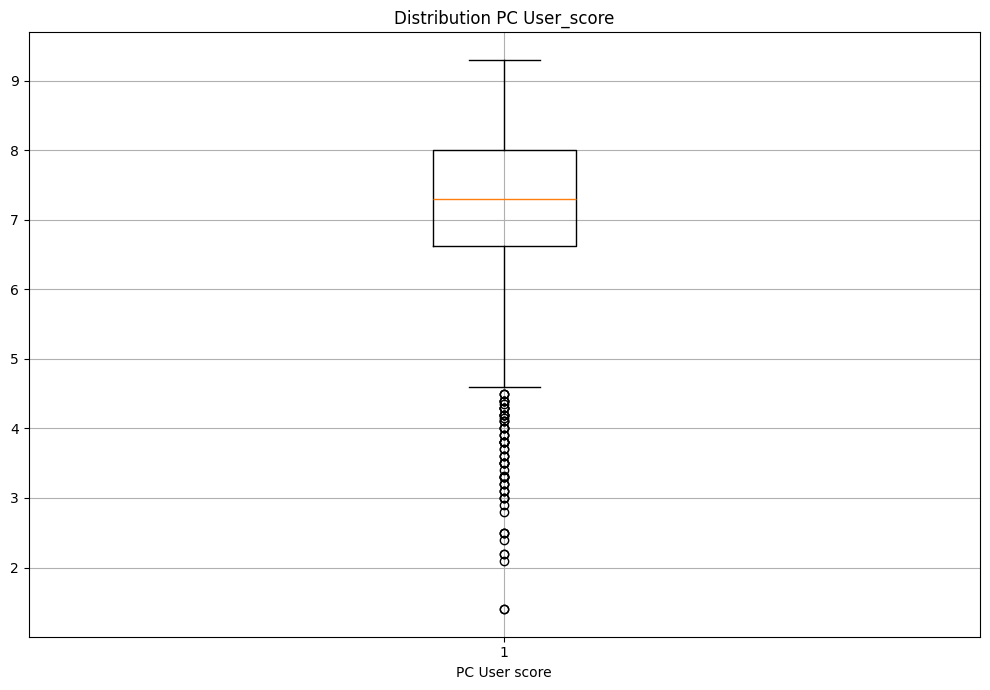

In [197]:
df_pc = df_games.loc[(df_games['platform'] == 'pc'),
                     'user_score'].reset_index(drop=True).to_frame()
plt.figure(figsize=(10, 7))
plt.boxplot(df_pc)

plt.xlabel('PC User score')
plt.title('Distribution PC User_score')
plt.grid(True)

plt.tight_layout()
plt.show()

##### `LSPL`

**_Note_:**

Thanks to extensive precleaning, the extreme user_score values ​​do not correspond to loading errors or fictitious values, but to real user ratings. This is evident in the distribution observed in the box plots. Therefore, for this analysis, outliers are not removed, as they represent genuine variability within each group and are part of the phenomenon being studied.

In [ ]:
# The average user ratings for the Xbox One and PC platforms are the same.

# 1. Propose Hypotheses H0, H1
# H0: The average user ratings for the Xbox One and PC platforms are the same (==)
# H1: The average user ratings for the Xbox One and PC platforms are different (!=)


xone_scores = df_games[(df_games['platform'] == 'xone') & (df_games['user_score'].notna())]['user_score']


pc_scores = df_games[(df_games['platform'] == 'pc') & (df_games['user_score'].notna())]['user_score']


print(f"XOne Size: {len(xone_scores)} | PC Size: {len(pc_scores)}")


# 2. Specify Significance or Confidence
# alpha = 5%
# confidence = 95%


alpha = 0.05

XOne Size: 247 | PC Size: 974


In [199]:
# Levene's test, to ensure that the variances of different samples are equal. Preventing tests such as ANOVA and t-tests from being incorrect.

levene_stat, levene_p = st.levene(xone_scores, pc_scores)
display(HTML(
    f"<b>Levene Statistical</b> – test: {levene_stat:.4f}, P-valor: {levene_p:.4f}"))

# Determinar igualdad de varianzas
if levene_p < 0.05:
    equal_var = False
    display(HTML("<i>Null hypothesis H₀ is rejected: the variances are different → use equal_var=False</i>"))
else:
    equal_var = True
    display(HTML("<i>Null hypothesis H₀ is not rejected: the variances are equal → use equal_var=True</i>"))

In [200]:
# 3. Calculate critical and test values, define acceptance and rejection zones

t_stat, p_value = st.ttest_ind(xone_scores, pc_scores, equal_var=equal_var)

display(HTML(f"T-statistic: <b>{t_stat:.4f}</b>"))
display(HTML(f"P-value: <b>{p_value:.4f}</b>"))

# 4. Decision and Conclusion

if p_value < alpha:
    display(HTML("<b>The null hypothesis is rejected</b>, because there is statistical evidence that <b>the average ratings of Xbox One and PC users differ.</b>"))
else:
    display(HTML("<b>We cannot reject the null hypothesis</b>, because there is not enough evidence to state that <b>the average ratings of Xbox One and PC users differ significantly</b>"))

##### **7.2** Hypothesis: "The average user ratings for the Action and Sports genres are different."

In [ ]:
# The average user ratings for action and sports genres are different.

# 1. Propose Hypotheses H0, H1
# H0: The average user ratings for action and sports genres are the same (==)
# H1: The average user ratings for action and sports genres are different (!=)


action_scores = df_games[(df_games['genre'] == 'action') & (


    df_games['user_score'].notna())]['user_score']


sports_scores = df_games[(df_games['genre'] == 'sports') & (


    df_games['user_score'].notna())]['user_score']

print(


    f"Action size: {len(action_scores)} | Sports Size: {len(sports_scores)}")


# 2. Specify Significance or Confidence
# alpha = 5%
# confidence = 95%


alpha = 0.05

Action size: 3369 | Sports Size: 2348


In [202]:
# Levene's test, to ensure that the variances of different samples are equal. Preventing tests such as ANOVA and t-tests from being incorrect.

levene_stat, levene_p = st.levene(action_scores, sports_scores)
display(HTML(
    f"<b>Levene Statistical</b> – test: {levene_stat:.4f}, P-valor: {levene_p:.4f}"))

# Determine equality of variances
if levene_p < 0.05:
    equal_var = False
    display(HTML("<i>Null hypothesis H₀ is rejected: the variances are different → use equal_var=False</i>"))
else:
    equal_var = True
    display(HTML("<i>Null hypothesis H₀ is not rejected: the variances are equal → use equal_var=True</i>"))

In [203]:
# 3. Calculate critical and test values, define acceptance and rejection zones

t_stat, p_value = st.ttest_ind(
    action_scores, sports_scores, equal_var=equal_var)

display(HTML(f"T-statistic: <b>{t_stat:.4f}</b>"))
display(HTML(f"P-value: <b>{p_value:.4f}</b>"))

# 4. Decision and Conclusion

if p_value < alpha:
    display(HTML("<b>The null hypothesis is rejected</b>, because there is sufficient statistical evidence to state that <b>the average ratings between the Action and Sports genres differ.</b>"))
else:
    display(HTML("<b>The alternative hypothesis is not rejected</b>, since there is insufficient evidence to state that <b>the average ratings between the Action and Sports genres differ significantly.</b>"))

##### `LSPL`

**_Note_:**

`Justification for the 'equal_var' parameter`

In hypothesis tests with `ttest_ind()`, the `equal_var` argument defines whether or not we assume equality of variances.
This parameter should NOT be decided based on sample sizes, but on the result of a formal test.

Therefore, we use Levene's test (`scipy.stats.levene`) to compare the variances of both groups:
- H₀: The variances of the groups are equal.
- H₁: The variances of the groups are different.

- If the p-value < 0.05 → We reject H₀ → unequal variances → `equal_var=False` (we use Welch's t test)
- If the p-value >= 0.05 → We do not reject H₀ → equal variances → `equal_var=True` (we use the standard Student's t test)

This validation ensures that the hypothesis test is based on sound statistical assumptions.

### 🎓 __8. Conclusion__

From the exploratory and statistical analysis of the video game dataset, key conclusions are obtained that allow us to understand market dynamics, technological evolution, and consumer preferences.

1. General Market Trends
A clear boom-bust cycle in video game sales was identified over the years. Platforms display typical patterns of introduction, growth, maturity, and decline.

The global market shows a concentration of sales in highly successful titles, generating a large number of positive outliers in the box plots, especially on platforms such as the Wii, DS, and PS2. This indicates that the most successful video game is the best-selling game, dominating sales compared to many games that sell for less than $1 million.

2. Regional Differences
North America (NA) leads total video game consumption, with a clear preference for titles rated "E" (Everyone) and genres such as Action and Sports.

Marked differences in preferences are observed in Europe (EU) and Japan (JP). Japan, for example, shows a greater preference for role-playing games (RPGs) and a greater tolerance for games with higher ratings such as "T" or "M".

Market shares vary significantly by region, highlighting the need for catalog segmentation and regional marketing.

3. Statistical Results
Significant differences were found between user ratings for platforms such as Xbox One vs. PC, and for genres such as Action vs. Sports, with p-values ​​< 0.05. This indicates that the perception of quality varies by platform type or genre.

Furthermore, clear differences were observed in the variability of scores, which could also correlate with the diversity of titles in each genre.

4. Strategic Recommendations
Promote multiplatform distribution for potentially successful titles.

Following dominant genres such as Action and Sports in North America, but diversifying into RPG and narrative genres in Asia.

Platforms with short lifecycles and low profitability (according to adjusted_profitability) should be avoided as a primary focus.

Leverage titles with high discrepancies between critics and users for marketing campaigns focused on player perception.

---

The analysis confirms that the video game market is largely dynamic and sensitive to regional preferences, the technological lifecycle, and consumer-perceived quality. Business decisions based solely on historical sales without considering these factors can be risky.

Through the use of exploratory analysis, effective visualizations, and statistical testing, this project provides a basis for making consumer-oriented decisions regarding the design and positioning of video games.